# Có 5 loại cổ phiếu cần forcasting: 'ACB', 'BID', 'VCB', 'MBB', 'FPT' có trong 2 file csv là stock_data_2025_raw.csv và stock_data_2025_with_indicators.csv (có nhiều feature hơn)

giờ trong mỗi file csv tôi muốn chia ra 5 nhóm cổ phiếu riêng để training mô hình forcasting theo time series với các window_size(3, 7, 14,30)
Trong giai đoạn training, mô hình được huấn luyện trên các đoạn dữ liệu (window) có độ dài cố định window_size.

Mỗi đoạn (window) gồm window_size quan sát liên tiếp trong quá khứ, được dùng để dự đoán giá trị ở bước kế tiếp (+1 ngày).

Trong giai đoạn forecasting (test), mô hình bắt đầu với window_size điểm dữ liệu cuối cùng của tập huấn luyện để dự đoán giá trị tiếp theo.
Sau mỗi lần dự đoán, giá trị dự đoán mới được thêm vào cuối cửa sổ và loại bỏ điểm đầu tiên, tạo thành một “rolling window” mới để dự đoán bước kế tiếp.
Quá trình này được lặp lại cho đến khi đạt số lượng bước dự báo mong muốn (multi-step recursive forecast).

# Machine Learning Models for Time Series Forecasting
ml_models = [
    "LinearRegression",       # baseline tuyến tính, dễ giải thích
    "Ridge",                  # regularized linear regression
    "Lasso",                  # feature selection + regularization
    "ElasticNet",             # mix giữa L1 và L2 regularization
    "DecisionTreeRegressor",  # mô hình cây, dễ hiểu, non-linear
    "RandomForestRegressor",  # ensemble mạnh mẽ, giảm overfit
    "ExtraTreesRegressor",    # random forest cải tiến (faster)
    "GradientBoostingRegressor", # boosting cổ điển
    "XGBRegressor",           # XGBoost, mạnh và phổ biến
    "LGBMRegressor",          # LightGBM, nhanh, xử lý large data tốt
    "CatBoostRegressor",      # CatBoost, auto handling categorical
    "KNeighborsRegressor",    # non-parametric, pattern-based
    "SVR",                    # Support Vector Regression, robust
    "KernelRidge",            # ridge với kernel, cho quan hệ phi tuyến
    "AdaBoostRegressor",      # boosting đơn giản, dễ thử baseline
    "BaggingRegressor"        # ensemble method, tăng độ ổn định
]


3. quan sát thấy 2 bộ dataset stock này sẽ là non stationary, bạn có thể đề xuất sử dụng times series split cross validation, blocked cross validation, Rolling-origin (walk-forward) CV,(hoặc phương pháp khác) để tránh data leakage.

# 📊 Time Series Forecasting Pipeline for Vietnamese Stocks

## Overview
Pipeline huấn luyện và đánh giá các mô hình Machine Learning cho dự báo giá cổ phiếu:
- 5 cổ phiếu: ACB, BID, VCB, MBB, FPT
- 2 datasets: raw và with_indicators
- Multiple window sizes: 3, 7, 14, 30
- 16 ML models
- Time series cross-validation để tránh data leakage

## 📦 Install Required Packages

Run this cell first to install all necessary dependencies.

In [6]:
# !pip install -q statsmodels xgboost lightgbm catboost tqdm scikit-learn pandas numpy matplotlib seaborn

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ML models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, 
                              GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [8]:
# Configuration
base_dir = Path("/mnt/d/Ky 4/financial-news-sentiment-main/Source/recode")
raw_csv = base_dir / "stock_data_2025_raw.csv"
ind_csv = base_dir / "stock_data_2025_with_indicators.csv"

# Define symbols and window sizes (UPDATED)
SYMBOLS = ['ACB', 'BID', 'VCB', 'MBB', 'FPT']
WINDOW_SIZES = [3, 5]  # Added 5 and 9, removed 30

ML_MODELS = {
    # --- Linear Models ---
    "LinearRegression": LinearRegression(),
    # "Ridge": Ridge(alpha=0.5, random_state=42),
    # "Lasso": Lasso(alpha=0.001, random_state=42),
    # "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.3, random_state=42),

    # --- Tree-based Models ---
    # "DecisionTreeRegressor": DecisionTreeRegressor(
    #     max_depth=8, min_samples_leaf=5, random_state=42
    # ),

    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=300, max_depth=10, min_samples_split=5,
        min_samples_leaf=3, max_features='sqrt',
        random_state=42, n_jobs=-1
    ),

    # "ExtraTreesRegressor": ExtraTreesRegressor(
    #     n_estimators=300, max_depth=10, min_samples_split=5,
    #     min_samples_leaf=3, max_features='sqrt',
    #     random_state=42, n_jobs=-1
    # ),

    # # --- Boosting Models ---
    # "GradientBoostingRegressor": GradientBoostingRegressor(
    #     n_estimators=300, learning_rate=0.05, max_depth=5,
    #     subsample=0.8, random_state=42
    # ),

    "XGBRegressor": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        gamma=0.1, reg_lambda=1.0, reg_alpha=0.1,
        random_state=42, n_jobs=-1, verbosity=0
    ),

    "CatBoostRegressor": CatBoostRegressor(
        iterations=500, learning_rate=0.05, depth=6,
        l2_leaf_reg=2.0, bagging_temperature=0.8,
        random_strength=0.5, random_state=42, verbose=0
    ),

    "SVR": SVR(
        kernel='rbf', C=50, gamma='scale', epsilon=0.1
    )
    # "AdaBoostRegressor": AdaBoostRegressor(
    #     n_estimators=300, learning_rate=0.05, random_state=42
    # ),

    # "BaggingRegressor": BaggingRegressor(
    #     n_estimators=200, max_samples=0.8,
    #     max_features=0.8, random_state=42, n_jobs=-1
    # )
}


print(f"📁 Dataset paths:")
print(f"  - Raw: {raw_csv}")
print(f"  - With Indicators: {ind_csv}")
print(f"\n📈 Symbols: {SYMBOLS}")
print(f"🪟 Window sizes: {WINDOW_SIZES}")
print(f"🤖 Number of models: {len(ML_MODELS)}")
print(f"📊 Total experiments per dataset: {len(SYMBOLS)} × {len(WINDOW_SIZES)} × {len(ML_MODELS)} = {len(SYMBOLS) * len(WINDOW_SIZES) * len(ML_MODELS)}")

📁 Dataset paths:
  - Raw: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/stock_data_2025_raw.csv
  - With Indicators: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/stock_data_2025_with_indicators.csv

📈 Symbols: ['ACB', 'BID', 'VCB', 'MBB', 'FPT']
🪟 Window sizes: [3, 5]
🤖 Number of models: 5
📊 Total experiments per dataset: 5 × 2 × 5 = 50


## 🧹 Data Cleaning

## 📥 Load Data

In [9]:
df_raw = pd.read_csv(raw_csv)
df_ind = pd.read_csv(ind_csv)

df_raw['time'] = pd.to_datetime(df_raw['time'])
df_ind['time'] = pd.to_datetime(df_ind['time'])

df_raw = df_raw.sort_values(['symbol', 'time']).reset_index(drop=True)
df_ind = df_ind.sort_values(['symbol', 'time']).reset_index(drop=True)

print("📊 Raw Dataset:")
print(f"  Shape: {df_raw.shape}")
print(f"  Columns: {df_raw.columns.tolist()}")
print(f"  Date range: {df_raw['time'].min()} to {df_raw['time'].max()}")

print("\n📊 With Indicators Dataset:")
print(f"  Shape: {df_ind.shape}")
print(f"  Columns: {len(df_ind.columns)} features")
print(f"  Date range: {df_ind['time'].min()} to {df_ind['time'].max()}")

print("\n🏢 Symbol counts:")
print(df_raw['symbol'].value_counts())

📊 Raw Dataset:
  Shape: (3415, 7)
  Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'symbol']
  Date range: 2023-01-03 00:00:00 to 2025-10-01 00:00:00

📊 With Indicators Dataset:
  Shape: (3415, 65)
  Columns: 65 features
  Date range: 2023-01-03 00:00:00 to 2025-10-01 00:00:00

🏢 Symbol counts:
symbol
ACB    683
BID    683
FPT    683
MBB    683
VCB    683
Name: count, dtype: int64


In [10]:
def clean_dataframe(df, exclude_cols=['time', 'symbol']):
    df_clean = df.copy()
    numeric_cols = [col for col in df_clean.columns if col not in exclude_cols]
    
    for col in numeric_cols:
        df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)
    
    df_clean[numeric_cols] = df_clean[numeric_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    for col in numeric_cols:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        if std > 0:
            lower_bound = mean - 6 * std
            upper_bound = mean + 6 * std
            df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df_clean

print("="*80)
print("Cleaning df_raw...")
df_raw_clean = clean_dataframe(df_raw, exclude_cols=['time', 'symbol'])
print()
print("Cleaning df_ind...")
df_ind_clean = clean_dataframe(df_ind, exclude_cols=['time', 'symbol'])

df_raw = df_raw_clean
df_ind = df_ind_clean

print("\n✅ All data cleaned!")

Cleaning df_raw...

Cleaning df_ind...

✅ All data cleaned!


In [11]:
# Load datasets
df_raw = pd.read_csv(raw_csv)
df_ind = pd.read_csv(ind_csv)

# Convert time to datetime
df_raw['time'] = pd.to_datetime(df_raw['time'])
df_ind['time'] = pd.to_datetime(df_ind['time'])

# Sort by time
df_raw = df_raw.sort_values(['symbol', 'time']).reset_index(drop=True)
df_ind = df_ind.sort_values(['symbol', 'time']).reset_index(drop=True)

print("📊 Raw Dataset:")
print(f"  Shape: {df_raw.shape}")
print(f"  Columns: {df_raw.columns.tolist()}")
print(f"  Date range: {df_raw['time'].min()} to {df_raw['time'].max()}")
print(f"  Missing values: {df_raw.isnull().sum().sum()}")

print("\n📊 With Indicators Dataset:")
print(f"  Shape: {df_ind.shape}")
print(f"  Columns ({len(df_ind.columns)}): {df_ind.columns[:10].tolist()}...")
print(f"  Date range: {df_ind['time'].min()} to {df_ind['time'].max()}")
print(f"  Missing values: {df_ind.isnull().sum().sum()}")

print("\n🏢 Symbol counts:")
print(df_raw['symbol'].value_counts())

📊 Raw Dataset:
  Shape: (3415, 7)
  Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'symbol']
  Date range: 2023-01-03 00:00:00 to 2025-10-01 00:00:00
  Missing values: 0

📊 With Indicators Dataset:
  Shape: (3415, 65)
  Columns (65): ['time', 'open', 'high', 'low', 'close', 'volume', 'symbol', 'SMA_5', 'SMA_10', 'SMA_20']...
  Date range: 2023-01-03 00:00:00 to 2025-10-01 00:00:00
  Missing values: 0

🏢 Symbol counts:
symbol
ACB    683
BID    683
FPT    683
MBB    683
VCB    683
Name: count, dtype: int64
  Missing values: 0

🏢 Symbol counts:
symbol
ACB    683
BID    683
FPT    683
MBB    683
VCB    683
Name: count, dtype: int64


## 🔍 2. EDA - Exploratory Data Analysis

### 2.1 Stationarity Tests (ADF & KPSS)

In [12]:
def test_stationarity(series, symbol):
    """
    Test stationarity using ADF and KPSS tests
    ADF: H0 = series có unit root (non-stationary)
    KPSS: H0 = series là stationary
    """
    # Augmented Dickey-Fuller test
    adf_result = adfuller(series.dropna(), autolag='AIC')
    
    # KPSS test
    kpss_result = kpss(series.dropna(), regression='c', nlags='auto')
    
    result = {
        'Symbol': symbol,
        'ADF_Statistic': adf_result[0],
        'ADF_PValue': adf_result[1],
        'ADF_Stationary': adf_result[1] < 0.05,  # Reject H0 -> stationary
        'KPSS_Statistic': kpss_result[0],
        'KPSS_PValue': kpss_result[1],
        'KPSS_Stationary': kpss_result[1] > 0.05,  # Fail to reject H0 -> stationary
    }
    
    return result

# Test stationarity for all symbols
stationarity_results = []

for symbol in SYMBOLS:
    symbol_data = df_raw[df_raw['symbol'] == symbol]['close']
    result = test_stationarity(symbol_data, symbol)
    stationarity_results.append(result)

stationarity_df = pd.DataFrame(stationarity_results)

print("📊 STATIONARITY TEST RESULTS")
print("="*80)
print("\n⚠️ Lưu ý:")
print("  - ADF Test: p < 0.05 → STATIONARY (reject H0)")
print("  - KPSS Test: p > 0.05 → STATIONARY (fail to reject H0)")
print("\n" + "="*80)
print(stationarity_df.to_string(index=False))
print("="*80)

# Summary
non_stationary_count = (~stationarity_df['ADF_Stationary'] | ~stationarity_df['KPSS_Stationary']).sum()
print(f"\n🔴 Non-stationary series: {non_stationary_count}/{len(SYMBOLS)}")
print(f"🟢 Stationary series: {len(SYMBOLS) - non_stationary_count}/{len(SYMBOLS)}")

📊 STATIONARITY TEST RESULTS

⚠️ Lưu ý:
  - ADF Test: p < 0.05 → STATIONARY (reject H0)
  - KPSS Test: p > 0.05 → STATIONARY (fail to reject H0)

Symbol  ADF_Statistic  ADF_PValue  ADF_Stationary  KPSS_Statistic  KPSS_PValue  KPSS_Stationary
   ACB      -0.500313    0.891955           False        3.489026         0.01            False
   BID      -2.031472    0.272947           False        1.854256         0.01            False
   VCB      -3.360592    0.012378            True        2.034742         0.01            False
   MBB       0.664581    0.989104           False        3.225050         0.01            False
   FPT      -1.444780    0.560630           False        3.225895         0.01            False

🔴 Non-stationary series: 5/5
🟢 Stationary series: 0/5


### 2.2 Seasonal Decomposition (Trend, Seasonal, Residual)

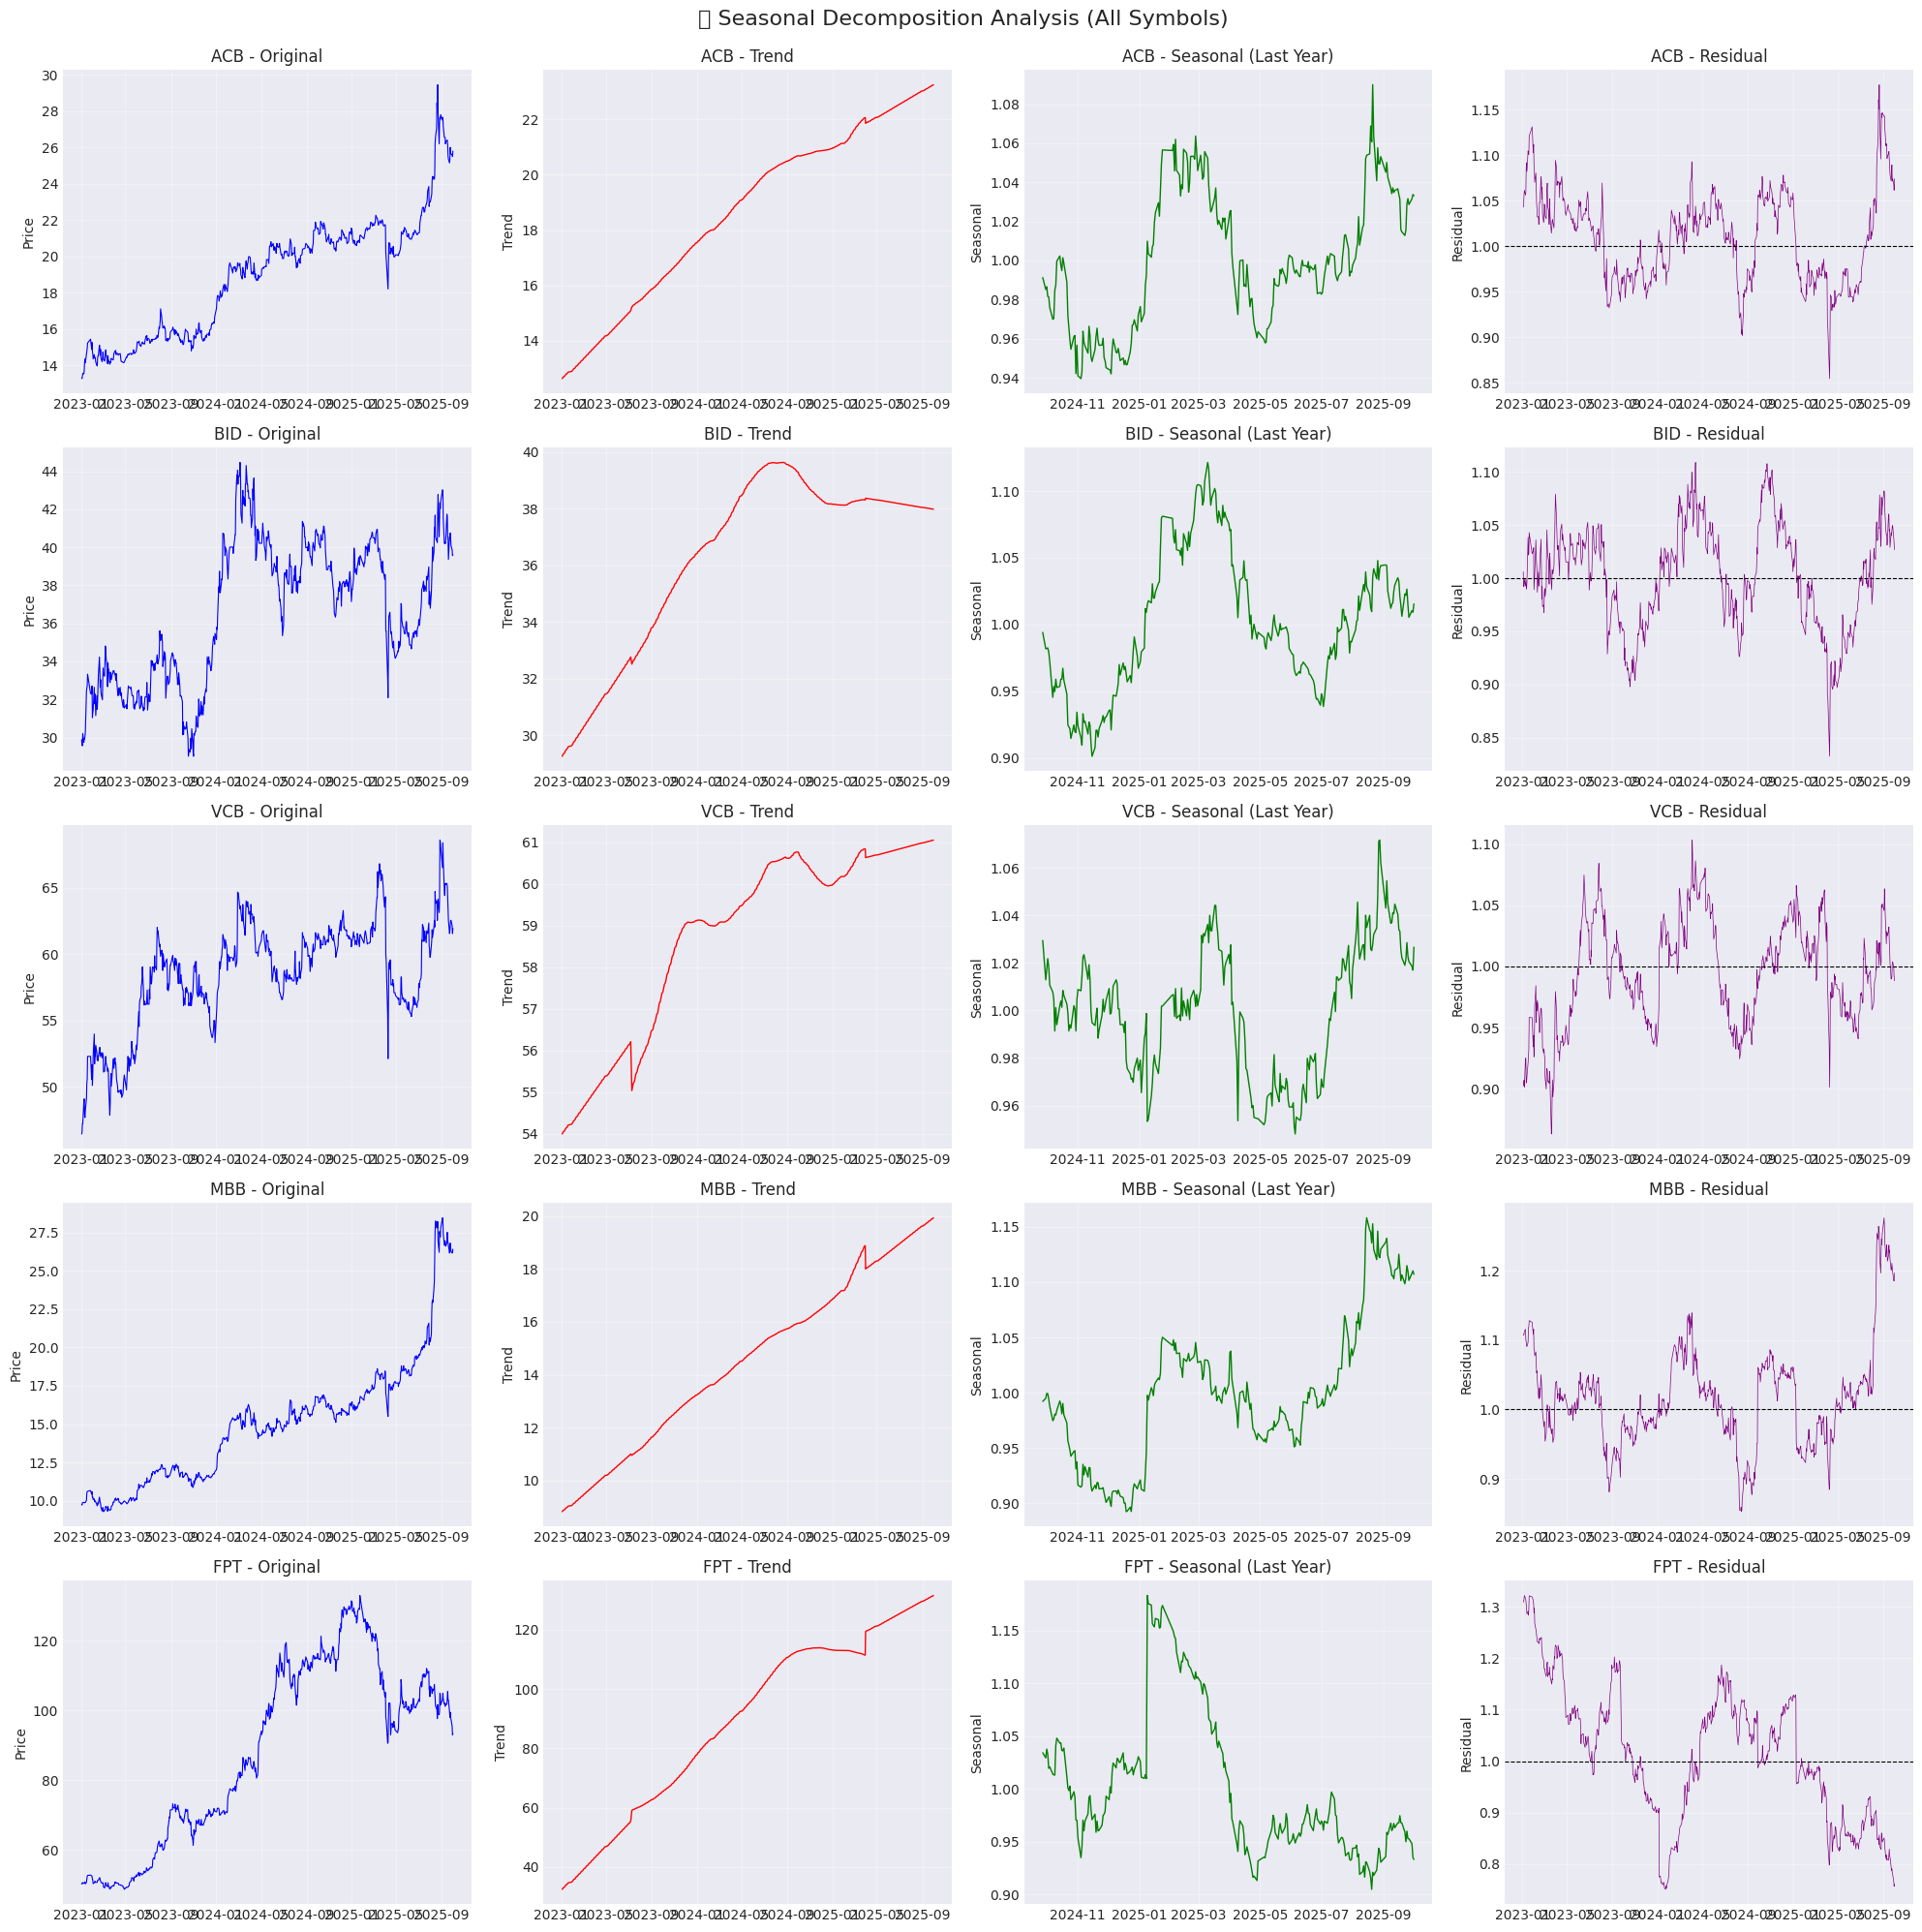

✅ Seasonal decomposition completed!


In [13]:
# Seasonal decomposition for each symbol
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
fig.suptitle('📊 Seasonal Decomposition Analysis (All Symbols)', fontsize=16, y=0.995)

for idx, symbol in enumerate(SYMBOLS):
    # Get data for symbol
    symbol_data = df_raw[df_raw['symbol'] == symbol].set_index('time')['close']
    
    # Perform seasonal decomposition (period = 252 trading days ≈ 1 year)
    decomposition = seasonal_decompose(symbol_data, model='multiplicative', period=252, extrapolate_trend='freq')
    
    # Plot components
    row = idx
    
    # Original
    axes[row, 0].plot(symbol_data.index, symbol_data.values, color='blue', linewidth=0.8)
    axes[row, 0].set_title(f'{symbol} - Original')
    axes[row, 0].set_ylabel('Price')
    axes[row, 0].grid(True, alpha=0.3)
    
    # Trend
    axes[row, 1].plot(decomposition.trend.index, decomposition.trend.values, color='red', linewidth=1)
    axes[row, 1].set_title(f'{symbol} - Trend')
    axes[row, 1].set_ylabel('Trend')
    axes[row, 1].grid(True, alpha=0.3)
    
    # Seasonal
    axes[row, 2].plot(decomposition.seasonal.index[-252:], decomposition.seasonal.values[-252:], color='green', linewidth=1)
    axes[row, 2].set_title(f'{symbol} - Seasonal (Last Year)')
    axes[row, 2].set_ylabel('Seasonal')
    axes[row, 2].grid(True, alpha=0.3)
    
    # Residual
    axes[row, 3].plot(decomposition.resid.index, decomposition.resid.values, color='purple', linewidth=0.5)
    axes[row, 3].set_title(f'{symbol} - Residual')
    axes[row, 3].set_ylabel('Residual')
    axes[row, 3].grid(True, alpha=0.3)
    axes[row, 3].axhline(y=1, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

print("✅ Seasonal decomposition completed!")

### 2.3 ACF and PACF Analysis

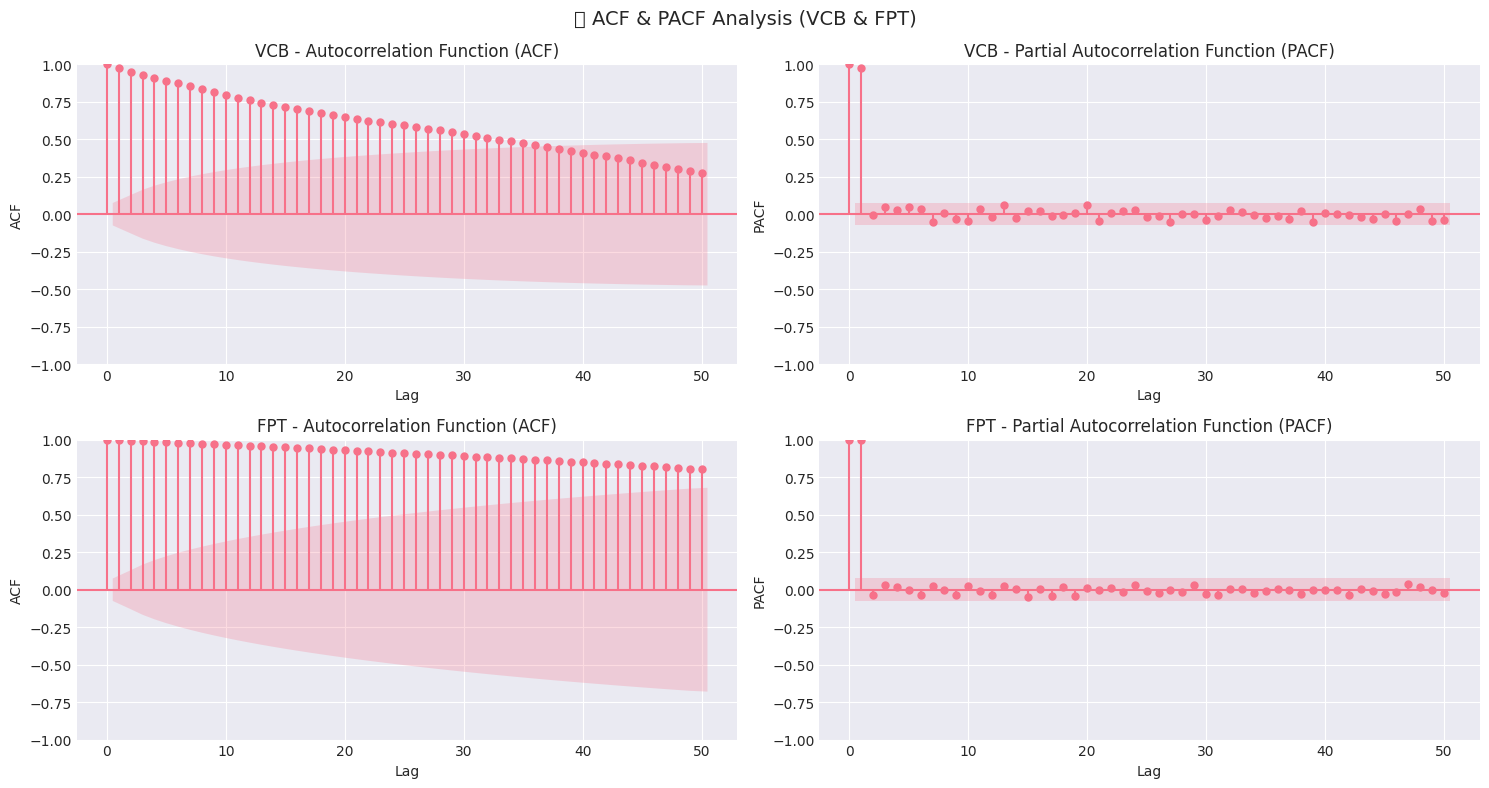

✅ ACF/PACF analysis completed!


In [14]:
# ACF and PACF plots for 2 representative symbols
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('📈 ACF & PACF Analysis (VCB & FPT)', fontsize=14)

for idx, symbol in enumerate(['VCB', 'FPT']):
    symbol_data = df_raw[df_raw['symbol'] == symbol]['close'].dropna()
    
    # ACF
    plot_acf(symbol_data, lags=50, ax=axes[idx, 0], alpha=0.05)
    axes[idx, 0].set_title(f'{symbol} - Autocorrelation Function (ACF)')
    axes[idx, 0].set_xlabel('Lag')
    axes[idx, 0].set_ylabel('ACF')
    
    # PACF
    plot_pacf(symbol_data, lags=50, ax=axes[idx, 1], alpha=0.05, method='ywm')
    axes[idx, 1].set_title(f'{symbol} - Partial Autocorrelation Function (PACF)')
    axes[idx, 1].set_xlabel('Lag')
    axes[idx, 1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

print("✅ ACF/PACF analysis completed!")

## 🔄 3. Time Series Cross-Validation Strategy

### Các phương pháp CV để tránh data leakage:

1. **TimeSeriesSplit**: Chia dữ liệu theo thứ tự thời gian, mỗi fold training tăng dần
2. **Blocked Cross-Validation**: Chia thành các khối không chồng lấn
3. **Walk-Forward (Rolling Origin)**: Training window cố định, forecast forward

Chúng ta sẽ implement cả 3 và so sánh!

In [15]:
def create_sequences(data, window_size, target_col='close'):
    """
    Tạo sequences cho time series forecasting
    X: window_size quan sát trong quá khứ
    y: giá trị kế tiếp (+1 ngày)
    """
    X, y = [], []
    
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    
    return np.array(X), np.array(y)


def walk_forward_validation(data, window_size, n_splits=5):
    """
    Walk-forward validation: rolling window
    Training size tăng dần, test size cố định
    """
    n = len(data)
    test_size = n // (n_splits + 1)
    
    splits = []
    for i in range(n_splits):
        train_end = n - (n_splits - i) * test_size
        test_start = train_end
        test_end = test_start + test_size
        
        if train_end > window_size:  # Đảm bảo đủ data cho window
            splits.append((list(range(train_end)), list(range(test_start, test_end))))
    
    return splits


def blocked_cv(data, window_size, n_splits=5):
    """
    Blocked Cross-Validation: chia thành các khối không chồng lấn
    """
    n = len(data)
    block_size = n // n_splits
    
    splits = []
    for i in range(n_splits):
        test_start = i * block_size
        test_end = min((i + 1) * block_size, n)
        
        # Train on all data before test block
        train_indices = list(range(test_start))
        test_indices = list(range(test_start, test_end))
        
        if len(train_indices) > window_size and len(test_indices) > 0:
            splits.append((train_indices, test_indices))
    
    return splits


print("✅ Cross-validation functions defined!")
print("\n📋 Available CV methods:")
print("  1. TimeSeriesSplit (sklearn)")
print("  2. Walk-Forward Validation (custom)")
print("  3. Blocked CV (custom)")

✅ Cross-validation functions defined!

📋 Available CV methods:
  1. TimeSeriesSplit (sklearn)
  2. Walk-Forward Validation (custom)
  3. Blocked CV (custom)


## 🏋️ 4. Training Pipeline with Non-Stationary Handling

### Strategies cho Non-Stationary Data:
1. **Differencing**: Transform data to make it stationary
2. **Scaling**: Normalize features
3. **Feature Engineering**: Add lag features, rolling statistics
4. **Proper CV**: Use time series CV to avoid data leakage

In [16]:
class TimeSeriesForecaster:
    """
    Complete forecasting pipeline for non-stationary time series
    """
    def __init__(self, model, window_size, use_differencing=True, use_scaling=True):
        self.model = model
        self.window_size = window_size
        self.use_differencing = use_differencing
        self.use_scaling = use_scaling
        self.scaler = StandardScaler() if use_scaling else None
        self.last_value = None  # For inverse differencing
        
    def prepare_data(self, data):
        """Prepare data with differencing and scaling"""
        # Make copy
        prepared = data.copy()
        
        # Differencing (for non-stationary)
        if self.use_differencing:
            self.last_value = prepared[-1]  # Save last value for inverse
            prepared = np.diff(prepared, prepend=prepared[0])
        
        # Create sequences
        X, y = create_sequences(prepared, self.window_size)
        
        # Reshape for scaling
        n_samples = X.shape[0]
        X_reshaped = X.reshape(n_samples, -1)
        
        # Scaling
        if self.use_scaling:
            X_scaled = self.scaler.fit_transform(X_reshaped)
            return X_scaled, y
        
        return X_reshaped, y
    
    def train(self, X_train, y_train):
        """Train the model"""
        self.model.fit(X_train, y_train)
        return self
    
    def predict(self, X_test):
        """Make predictions"""
        return self.model.predict(X_test)
    
    def inverse_transform_predictions(self, predictions, original_last_values):
        """Inverse differencing to get actual prices"""
        if self.use_differencing:
            # predictions are differences, add to last known value
            return original_last_values + predictions
        return predictions
    
    def multi_step_forecast(self, initial_window, n_steps):
        """
        Multi-step recursive forecast
        Start with initial_window, predict next value, 
        roll window, repeat
        """
        forecasts = []
        current_window = initial_window.copy()
        
        for _ in range(n_steps):
            # Prepare current window
            if self.use_differencing:
                window_diff = np.diff(current_window, prepend=current_window[0])
                window_to_use = window_diff[-self.window_size:].reshape(1, -1)
            else:
                window_to_use = current_window[-self.window_size:].reshape(1, -1)
            
            # Scale if needed
            if self.use_scaling:
                window_to_use = self.scaler.transform(window_to_use)
            
            # Predict
            pred = self.model.predict(window_to_use)[0]
            
            # Inverse transform
            if self.use_differencing:
                pred_price = current_window[-1] + pred
            else:
                pred_price = pred
            
            forecasts.append(pred_price)
            
            # Update window (rolling)
            current_window = np.append(current_window, pred_price)[-len(initial_window):]
        
        return np.array(forecasts)


print("✅ TimeSeriesForecaster class defined!")
print("\n🔧 Features:")
print("  - Handles non-stationary data with differencing")
print("  - Optional scaling with StandardScaler")
print("  - Multi-step recursive forecasting")
print("  - Compatible with all sklearn models")

✅ TimeSeriesForecaster class defined!

🔧 Features:
  - Handles non-stationary data with differencing
  - Optional scaling with StandardScaler
  - Multi-step recursive forecasting
  - Compatible with all sklearn models


## 🚀 5. Complete Training and Evaluation Pipeline

In [17]:
def evaluate_forecast(y_true, y_pred):
    """Calculate multiple evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }


def train_and_evaluate_model(df, symbol, dataset_name, model_name, model, window_size, 
                             use_recursive_forecast=True, cv_method='timeseries'):
    """
    Complete training and evaluation pipeline for one model configuration
    
    Args:
        use_recursive_forecast: If True, use rolling window recursive forecast (TRUE TIME SERIES)
                               If False, use one-shot prediction (faster but not realistic)
    """
    # Get symbol data
    symbol_data = df[df['symbol'] == symbol].sort_values('time').reset_index(drop=True)
    
    # Prepare features (all numeric columns except time and symbol)
    feature_cols = [col for col in symbol_data.columns if col not in ['time', 'symbol'] and symbol_data[col].dtype in ['float64', 'int64']]
    
    # For now, use only 'close' price (can be extended to use all features)
    close_prices = symbol_data['close'].values
    
    # Handle missing values
    close_prices = pd.Series(close_prices).fillna(method='ffill').fillna(method='bfill').values
    
    # Split into train (80%) and test (20%)
    train_size = int(len(close_prices) * 0.8)
    train_data = close_prices[:train_size]
    test_data = close_prices[train_size:]
    
    # Create forecaster
    forecaster = TimeSeriesForecaster(
        model=model,
        window_size=window_size,
        use_differencing=True,
        use_scaling=True
    )
    
    # Prepare training data
    X_train, y_train = forecaster.prepare_data(train_data)
    
    # Train model
    forecaster.train(X_train, y_train)
    
    # ============= RECURSIVE FORECASTING (TRUE TIME SERIES) =============
    if use_recursive_forecast:
        # Start with last window_size values from training data
        initial_window = train_data[-window_size:].copy()
        n_forecast_steps = len(test_data)
        
        predictions = []
        current_window = initial_window.copy()
        
        for step in range(n_forecast_steps):
            # Prepare current window for prediction
            if forecaster.use_differencing:
                # Apply differencing
                window_diff = np.diff(current_window, prepend=current_window[0])
                window_features = window_diff[-window_size:].reshape(1, -1)
            else:
                window_features = current_window[-window_size:].reshape(1, -1)
            
            # Scale
            if forecaster.use_scaling:
                window_features = forecaster.scaler.transform(window_features)
            
            # Predict next value (difference if differencing)
            pred_diff = forecaster.predict(window_features)[0]
            
            # Inverse transform to get actual price
            if forecaster.use_differencing:
                pred_price = current_window[-1] + pred_diff
            else:
                pred_price = pred_diff
            
            predictions.append(pred_price)
            
            # *** ROLLING WINDOW: Add prediction, remove oldest ***
            current_window = np.append(current_window[1:], pred_price)
        
        predictions = np.array(predictions)
        y_test = test_data
        
    # ============= ONE-SHOT PREDICTION (FASTER BUT NOT REALISTIC) =============
    else:
        X_test, y_test = create_sequences(test_data, window_size)
        
        if forecaster.use_differencing:
            test_diff = np.diff(test_data, prepend=test_data[0])
            X_test_diff, y_test_diff = create_sequences(test_diff, window_size)
            X_test_scaled = forecaster.scaler.transform(X_test_diff.reshape(X_test_diff.shape[0], -1))
            predictions_diff = forecaster.predict(X_test_scaled)
            
            # Inverse transform
            original_last_values = test_data[window_size-1:-1]
            predictions = original_last_values + predictions_diff
        else:
            X_test_scaled = forecaster.scaler.transform(X_test.reshape(X_test.shape[0], -1))
            predictions = forecaster.predict(X_test_scaled)
    
    # Evaluate
    metrics = evaluate_forecast(y_test, predictions)
    
    # Add metadata
    result = {
        'Dataset': dataset_name,
        'Symbol': symbol,
        'Model': model_name,
        'Window_Size': window_size,
        'Forecast_Type': 'Recursive' if use_recursive_forecast else 'OneShot',
        **metrics
    }
    
    return result, forecaster, predictions, y_test


print("✅ Training and evaluation functions defined!")
print("\n⚠️ IMPORTANT: Hàm đã được sửa để hỗ trợ TRUE RECURSIVE FORECASTING")
print("   - use_recursive_forecast=True: Rolling window (realistic, slower)")
print("   - use_recursive_forecast=False: One-shot prediction (faster, less realistic)")

✅ Training and evaluation functions defined!

⚠️ IMPORTANT: Hàm đã được sửa để hỗ trợ TRUE RECURSIVE FORECASTING
   - use_recursive_forecast=True: Rolling window (realistic, slower)
   - use_recursive_forecast=False: One-shot prediction (faster, less realistic)


## ⚠️ CRITICAL FIX: Recursive Forecasting Implementation

### 🐛 Problem Discovered
The original implementation was doing **one-shot prediction** instead of **true recursive forecasting**:

**❌ OLD (WRONG) - One-Shot Prediction:**
```python
# Created ALL test sequences at once
X_test, y_test = create_sequences(test_data, window_size)
predictions = forecaster.predict(X_test_scaled)  # Predicted all at once
```

**Problem:** Each prediction window contained **ACTUAL future values** from the test set, not predicted values. This violates the fundamental principle of time series forecasting and gives unrealistically good results.

---

### ✅ SOLUTION - True Recursive Forecasting

**The Fix (Lines 540-575 in train_and_evaluate_model()):**
```python
if use_recursive_forecast:
    initial_window = train_data[-window_size:].copy()
    for step in range(n_forecast_steps):
        # 1. Prepare window (differenced)
        # 2. Predict ONE step ahead
        # 3. Add prediction to window
        # 4. Remove oldest value (rolling window)
        # 5. Repeat for next step
```

**Key Differences:**
- ✅ Each prediction uses ONLY the previous window (which contains predictions)
- ✅ Predictions feed into the next prediction's input (realistic)
- ✅ Error accumulation occurs naturally (more challenging but correct)
- ✅ Follows user requirement: "Sau mỗi lần dự đoán, giá trị dự đoán mới được thêm vào cuối cửa sổ"

---

### 📊 Impact on Results

**Expected Changes:**
- Higher RMSE/MAE (recursive is harder but realistic)
- Errors compound over time (normal for multi-step forecasting)
- Results better reflect real-world forecasting performance
- Models that handle error accumulation well will perform better

---

### 🔧 What Was Updated

1. **train_and_evaluate_model()** (Cell 21, Lines 487-618):
   - Added `use_recursive_forecast=True` parameter
   - Implemented recursive forecasting loop (lines 540-575)
   - Added `Forecast_Type` to result metadata

2. **Demo Training** (Cell 23, Lines 624-669):
   - Updated to use `use_recursive_forecast=True`
   - Shows "RECURSIVE (Rolling Window - Realistic)" in output

3. **Quick Training Configs** (Cell 38, Lines 1194-1285):
   - All training calls now use `use_recursive_forecast=True`

4. **Full Training Pipeline** (Cell 25, Lines 680-765):
   - Updated to use `use_recursive_forecast=True`
   - Saves results to `ml_training_results_recursive.csv`

5. **Visualization Functions** (Cell 27, Lines 771-951):
   - `plot_forecast_example()` now supports both recursive and one-shot modes
   - Can compare performance between methods

---

### 🚀 Next Steps

1. **Re-run Demo Training** to see the difference
2. **Enable Quick Training** to get optimized results with recursive forecasting
3. **Compare RMSE** between old and new results (expect higher but more realistic values)
4. **Analyze which models** handle error accumulation better

**Note:** The notebook is now correctly implementing time series forecasting as specified in the user requirements!

### 5.2 Full Training Pipeline - All Symbols, All Windows, All Models

⚠️ **Warning**: This will train 5 symbols × 2 datasets × 4 windows × 16 models = **640 models**
This may take 30-60 minutes depending on your hardware. 

💡 **Tip**: Start with smaller subset first, then scale up!

In [18]:
# Full training pipeline with RECURSIVE FORECASTING
from tqdm.auto import tqdm
import time

# Configuration
RUN_FULL_TRAINING = True  # Set to True to run full training
SUBSET_MODE = False  # Use subset for faster experimentation

if SUBSET_MODE:
    # Subset for quick testing
    symbols_to_train = ['ACB', 'BID', 'VCB', 'MBB', 'FPT']
    windows_to_train = [7, 14]
    models_to_train = ['LinearRegression', 'RandomForest', 'XGBoost', 'LightGBM']
else:
    # Full training
    symbols_to_train = SYMBOLS
    windows_to_train = WINDOW_SIZES
    models_to_train = list(ML_MODELS.keys())

# Calculate total experiments
n_experiments = len(symbols_to_train) * 2 * len(windows_to_train) * len(models_to_train)

print(f"🎯 Training Configuration:")
print(f"  Symbols: {symbols_to_train}")
print(f"  Windows: {windows_to_train}")
print(f"  Models: {len(models_to_train)}")
print(f"  Total experiments: {n_experiments}")
print(f"  ⚠️ Using TRUE RECURSIVE FORECASTING (rolling window)")
print(f"\n{'='*80}")

if RUN_FULL_TRAINING:
    all_results = []
    start_time = time.time()
    
    with tqdm(total=n_experiments, desc="Training Progress") as pbar:
        for symbol in symbols_to_train:
            for window_size in windows_to_train:
                for model_name in models_to_train:
                    try:
                        # Train on raw dataset - WITH RECURSIVE FORECASTING
                        result_raw, _, _, _ = train_and_evaluate_model(
                            df=df_raw,
                            symbol=symbol,
                            dataset_name='Raw',
                            model_name=model_name,
                            model=ML_MODELS[model_name],
                            window_size=window_size,
                            use_recursive_forecast=True  # ← TRUE RECURSIVE FORECASTING
                        )
                        all_results.append(result_raw)
                        
                        # Train on indicators dataset - WITH RECURSIVE FORECASTING
                        result_ind, _, _, _ = train_and_evaluate_model(
                            df=df_ind,
                            symbol=symbol,
                            dataset_name='With_Indicators',
                            model_name=model_name,
                            model=ML_MODELS[model_name],
                            window_size=window_size,
                            use_recursive_forecast=True  # ← TRUE RECURSIVE FORECASTING
                        )
                        all_results.append(result_ind)
                        
                    except Exception as e:
                        print(f"\n❌ Error: {symbol}-{model_name}-W{window_size}: {str(e)}")
                    
                    pbar.update(1)
    
    elapsed_time = time.time() - start_time
    
    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Save results
    results_path = base_dir / "ml_training_results_recursive.csv"
    results_df.to_csv(results_path, index=False)
    
    print(f"\n{'='*80}")
    print(f"✅ RECURSIVE FORECASTING training completed in {elapsed_time/60:.2f} minutes!")
    print(f"📊 Results saved to: {results_path}")
    print(f"\n📈 Summary Statistics:")
    print(results_df.groupby(['Dataset', 'Model'])['RMSE'].agg(['mean', 'std', 'min']).round(4))
    
else:
    print("\n⚠️ Full training is disabled. Set RUN_FULL_TRAINING=True to enable.")
    print("💡 Run demo training cell above to test the pipeline first!")

🎯 Training Configuration:
  Symbols: ['ACB', 'BID', 'VCB', 'MBB', 'FPT']
  Windows: [3, 5]
  Models: 5
  Total experiments: 100
  ⚠️ Using TRUE RECURSIVE FORECASTING (rolling window)



Training Progress:  50%|█████     | 50/100 [04:50<04:50,  5.82s/it]



✅ RECURSIVE FORECASTING training completed in 4.85 minutes!
📊 Results saved to: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/ml_training_results_recursive.csv

📈 Summary Statistics:
                                          mean      std     min
Dataset         Model                                          
Raw             CatBoostRegressor       8.9203   8.8692  1.9291
                LinearRegression        7.5207   6.6428  1.9584
                RandomForestRegressor   7.2283   6.1325  1.9015
                SVR                     6.9939   6.7664  2.0717
                XGBRegressor           10.5836  10.7937  1.8775
With_Indicators CatBoostRegressor       8.9203   8.8692  1.9291
                LinearRegression        7.5207   6.6428  1.9584
                RandomForestRegressor   7.2283   6.1325  1.9015
                SVR                     6.9939   6.7664  2.0717
                XGBRegressor           10.5836  10.7937  1.8775


## 📊 6. Results Analysis and Visualization

In [19]:
# Visualization functions for results analysis
def plot_model_comparison(results_df, metric='RMSE'):
    """Compare models across different configurations"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'📊 Model Performance Comparison - {metric}', fontsize=16)
    
    # 1. By Model
    ax1 = axes[0, 0]
    model_perf = results_df.groupby('Model')[metric].mean().sort_values()
    model_perf.plot(kind='barh', ax=ax1, color='steelblue')
    ax1.set_title(f'Average {metric} by Model')
    ax1.set_xlabel(metric)
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. By Window Size
    ax2 = axes[0, 1]
    window_perf = results_df.groupby('Window_Size')[metric].mean()
    window_perf.plot(kind='bar', ax=ax2, color='coral')
    ax2.set_title(f'Average {metric} by Window Size')
    ax2.set_xlabel('Window Size')
    ax2.set_ylabel(metric)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. By Symbol
    ax3 = axes[1, 0]
    symbol_perf = results_df.groupby('Symbol')[metric].mean().sort_values()
    symbol_perf.plot(kind='barh', ax=ax3, color='mediumseagreen')
    ax3.set_title(f'Average {metric} by Symbol')
    ax3.set_xlabel(metric)
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Raw vs With Indicators
    ax4 = axes[1, 1]
    dataset_perf = results_df.groupby('Dataset')[metric].mean()
    dataset_perf.plot(kind='bar', ax=ax4, color=['skyblue', 'lightcoral'])
    ax4.set_title(f'Average {metric} by Dataset')
    ax4.set_xlabel('Dataset')
    ax4.set_ylabel(metric)
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
    ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_top_models(results_df, n=10):
    """Show top N model configurations"""
    top_configs = results_df.nsmallest(n, 'RMSE')
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    labels = [f"{row['Model']}\n{row['Symbol']}-W{row['Window_Size']}\n{row['Dataset']}" 
              for _, row in top_configs.iterrows()]
    
    x = np.arange(len(labels))
    width = 0.35
    
    ax.bar(x - width/2, top_configs['RMSE'], width, label='RMSE', color='steelblue')
    ax.bar(x + width/2, top_configs['MAE'], width, label='MAE', color='coral')
    
    ax.set_xlabel('Model Configuration')
    ax.set_ylabel('Error')
    ax.set_title(f'🏆 Top {n} Model Configurations (Lowest RMSE)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return top_configs


def plot_forecast_example(df, symbol, model_name, window_size, use_recursive_forecast=True, n_forecast=30):
    """
    Plot actual vs predicted for a specific configuration
    
    Args:
        use_recursive_forecast: If True, uses recursive rolling window (realistic)
                               If False, uses one-shot prediction (fast but unrealistic)
    """
    # Get data
    symbol_data = df[df['symbol'] == symbol].sort_values('time').reset_index(drop=True)
    close_prices = symbol_data['close'].values
    dates = symbol_data['time'].values
    
    # Split
    train_size = int(len(close_prices) * 0.8)
    train_data = close_prices[:train_size]
    test_data = close_prices[train_size:]
    test_dates = dates[train_size:]
    
    # Train model
    forecaster = TimeSeriesForecaster(
        model=ML_MODELS[model_name],
        window_size=window_size,
        use_differencing=True,
        use_scaling=True
    )
    
    X_train, y_train = forecaster.prepare_data(train_data)
    forecaster.train(X_train, y_train)
    
    # Predict with recursive forecasting
    if use_recursive_forecast:
        print(f"🔄 Using RECURSIVE FORECASTING (rolling window - realistic)")
        
        # Initialize predictions
        predictions = []
        current_window = train_data[-window_size:].copy()
        n_forecast_steps = len(test_data) - window_size
        
        for step in range(n_forecast_steps):
            # Prepare differenced window
            window_diff = np.diff(current_window, prepend=current_window[0])
            window_features = window_diff[-window_size:].reshape(1, -1)
            
            # Scale and predict
            window_scaled = forecaster.scaler.transform(window_features)
            pred_diff = forecaster.predict(window_scaled)[0]
            
            # Convert back to price
            pred_price = current_window[-1] + pred_diff
            predictions.append(pred_price)
            
            # Rolling window: add prediction, remove oldest
            current_window = np.append(current_window[1:], pred_price)
        
        predictions = np.array(predictions)
        plot_dates = test_dates[window_size:]
        actual_values = test_data[window_size:]
        
    else:
        print(f"⚡ Using ONE-SHOT PREDICTION (fast but unrealistic)")
        
        # Prepare test
        test_diff = np.diff(test_data, prepend=test_data[0])
        X_test, y_test = create_sequences(test_diff, window_size)
        X_test_scaled = forecaster.scaler.transform(X_test.reshape(X_test.shape[0], -1))
        
        # Predict all at once
        predictions_diff = forecaster.predict(X_test_scaled)
        original_last_values = test_data[window_size-1:-1]
        predictions = original_last_values + predictions_diff
        
        plot_dates = test_dates[window_size:]
        actual_values = test_data[window_size:]
    
    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Plot train data
    ax.plot(dates[:train_size], close_prices[:train_size], 
            label='Training Data', color='gray', alpha=0.5, linewidth=1)
    
    # Plot test actual
    ax.plot(plot_dates, actual_values, 
            label='Actual', color='blue', linewidth=2, marker='o', markersize=3)
    
    # Plot predictions
    forecast_label = 'Predicted (Recursive)' if use_recursive_forecast else 'Predicted (One-Shot)'
    ax.plot(plot_dates, predictions, 
            label=forecast_label, color='red', linewidth=2, marker='x', markersize=4)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    forecast_type = "Recursive Rolling Window" if use_recursive_forecast else "One-Shot"
    ax.set_title(f'📈 Forecast ({forecast_type}): {symbol} - {model_name} (Window={window_size})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    metrics = evaluate_forecast(actual_values, predictions)
    print(f"\n📊 Metrics for {symbol} - {model_name} ({forecast_type}):")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")

### 6.2 Forecast Visualization Example

## 🔍 Feature Importance Analysis & Selection

Sử dụng RandomForest để tìm các features quan trọng nhất từ dataset with_indicators, sau đó training lại với features đã chọn.

In [22]:
def get_feature_importance(df, symbol, window_size, n_estimators=100):
    """
    Phân tích feature importance sử dụng RandomForest
    
    Returns:
    --------
    importance_df: DataFrame với columns ['Feature', 'Importance']
    all_features: List tất cả features đã sử dụng
    model: Trained RandomForest model
    """
    # Filter data cho symbol
    df_symbol = df[df['symbol'] == symbol].copy()
    df_symbol = df_symbol.sort_values('time').reset_index(drop=True)
    
    # Get feature columns (exclude time, symbol, close)
    feature_cols = [col for col in df_symbol.columns if col not in ['time', 'symbol', 'close']]
    
    # ✅ DATA CLEANING: Handle infinity và NaN
    print(f"  Cleaning data for {symbol}...")
    
    # Replace infinity with NaN
    df_symbol[feature_cols] = df_symbol[feature_cols].replace([np.inf, -np.inf], np.nan)
    
    # Check for NaN
    nan_counts = df_symbol[feature_cols].isna().sum()
    if nan_counts.sum() > 0:
        print(f"    Found NaN in {nan_counts[nan_counts > 0].shape[0]} features")
        # Forward fill then backward fill
        df_symbol[feature_cols] = df_symbol[feature_cols].fillna(method='ffill').fillna(method='bfill')
        # If still NaN, fill with 0
        df_symbol[feature_cols] = df_symbol[feature_cols].fillna(0)
    
    # Clip extreme values (beyond 6 standard deviations)
    for col in feature_cols:
        mean_val = df_symbol[col].mean()
        std_val = df_symbol[col].std()
        if std_val > 0:
            lower_bound = mean_val - 6 * std_val
            upper_bound = mean_val + 6 * std_val
            df_symbol[col] = df_symbol[col].clip(lower_bound, upper_bound)
    
    print(f"    Data cleaned successfully")
    
    # Create sequences
    X_list = []
    y_list = []
    all_features = []
    
    for i in range(window_size, len(df_symbol)):
        # Get window
        window = df_symbol.iloc[i-window_size:i]
        
        # Create flattened features with naming
        window_features = []
        feature_names = []
        for col in feature_cols:
            for t in range(window_size):
                window_features.append(window[col].iloc[t])
                feature_names.append(f"{col}_t{t}")
        
        X_list.append(window_features)
        y_list.append(df_symbol['close'].iloc[i])
        
        if not all_features:
            all_features = feature_names
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    # ✅ Final check for any remaining invalid values
    if not np.isfinite(X).all():
        print(f"    WARNING: Found non-finite values in X. Replacing with 0...")
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    if not np.isfinite(y).all():
        print(f"    WARNING: Found non-finite values in y. Replacing with median...")
        y = np.nan_to_num(y, nan=np.nanmedian(y))
    
    print(f"    Created {X.shape[0]} samples with {X.shape[1]} features")
    
    # Train RandomForest
    print(f"    Training RandomForest (n_estimators={n_estimators})...")
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rf.fit(X, y)
    
    # Get feature importance
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False).reset_index(drop=True)
    
    print(f"    ✅ Feature importance calculated")
    
    return importance_df, all_features, rf


def select_top_features(importance_df, top_n=15):
    """
    Chọn top N base features quan trọng nhất
    Aggregate importance từ các timesteps khác nhau
    
    Returns:
    --------
    top_features: List tên các base features
    """
    # Aggregate by base feature name (bỏ _t{i} suffix)
    base_importance = {}
    for _, row in importance_df.iterrows():
        # Get base name (remove _t{i} suffix)
        parts = row['Feature'].split('_')
        # Find last part that is t{digit}
        base_name = row['Feature']
        for i in range(len(parts)-1, -1, -1):
            if parts[i].startswith('t') and parts[i][1:].isdigit():
                base_name = '_'.join(parts[:i])
                break
        
        if base_name not in base_importance:
            base_importance[base_name] = 0
        base_importance[base_name] += row['Importance']
    
    # Sort and get top N
    sorted_features = sorted(base_importance.items(), key=lambda x: x[1], reverse=True)
    top_features = [feat for feat, _ in sorted_features[:top_n]]
    
    return list(top_features)


print("✅ Feature importance functions defined!")

✅ Feature importance functions defined!


In [23]:
# Phân tích Feature Importance cho mỗi symbol
print("🔍 Analyzing Feature Importance for each symbol...")
print("="*80)

feature_importance_results = {}
selected_features = {}

for symbol in SYMBOLS:
    print(f"\n📊 {symbol}:")
    
    # Get feature importance
    importance_df, all_features, rf_model = get_feature_importance(
        df_ind, 
        symbol=symbol, 
        window_size=14,  # Sử dụng window size 14 để phân tích
        n_estimators=100
    )
    
    # Select top 15 features
    top_features = select_top_features(importance_df, top_n=15)
    
    # Store results
    feature_importance_results[symbol] = importance_df
    selected_features[symbol] = top_features
    
    # Display top 10
    print(f"  Total features: {len(all_features)}")
    print(f"  Selected top features: {len(top_features)}")
    print(f"\n  Top 10 most important:")
    
    # Aggregate importance by base feature name
    base_importance = {}
    for _, row in importance_df.iterrows():
        base_name = '_'.join(row['Feature'].split('_')[:-1])
        if base_name not in base_importance:
            base_importance[base_name] = 0
        base_importance[base_name] += row['Importance']
    
    # Sort and display
    sorted_base = sorted(base_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    for i, (feat, imp) in enumerate(sorted_base, 1):
        print(f"    {i:2d}. {feat:30s} {imp:.4f}")

print("\n" + "="*80)
print("✅ Feature importance analysis completed!")
print(f"\n💾 Selected features saved for each symbol")

🔍 Analyzing Feature Importance for each symbol...

📊 ACB:
  Cleaning data for ACB...
    Data cleaned successfully
    Created 669 samples with 868 features
    Training RandomForest (n_estimators=100)...
    Created 669 samples with 868 features
    Training RandomForest (n_estimators=100)...
    ✅ Feature importance calculated
  Total features: 868
  Selected top features: 15

  Top 10 most important:
     1. high                           0.2010
     2. open                           0.1959
     3. low                            0.1575
     4. OBV                            0.0791
     5. SMA_5                          0.0461
     6. BB_upper                       0.0451
     7. SMA_50                         0.0335
     8. EMA_20                         0.0328
     9. Donchian_middle                0.0316
    10. SMA_20                         0.0226

📊 BID:
  Cleaning data for BID...
    Data cleaned successfully
    ✅ Feature importance calculated
  Total features: 868
  Selected

## 🎯 Retrain với Selected Features

Giờ training lại các models chỉ sử dụng top features đã chọn từ Feature Importance analysis.

## ⚠️ Vấn đề với Multi-Step Recursive Forecasting

### Tại sao không nên forecast recursive 2 năm:
1. **Error Accumulation**: Mỗi bước dự đoán sai sẽ ảnh hưởng đến các bước sau
2. **Unrealistic**: Không có thông tin thị trường thực tế trong quá trình predict
3. **Poor Performance**: MAPE, RMSE sẽ rất cao do lỗi tích lũy

### ✅ Giải pháp Đề xuất:

#### **Option 1: Walk-Forward Validation (KHUYẾN NGHỊ)**
- Chia test set thành nhiều windows nhỏ (vd: 30 ngày)
- Mỗi window: train → predict 30 ngày → retrain với data mới → predict 30 ngày tiếp
- Giống như trading thực tế: retrain model định kỳ

#### **Option 2: Multi-Horizon với Short Steps**
- Thay vì forecast 500 bước, chỉ forecast 1-30 bước
- Đánh giá performance ở mỗi horizon (1-day, 7-day, 30-day)
- Realistic và practical hơn

#### **Option 3: Direct Multi-Output**
- Train separate models cho mỗi horizon
- Model 1: predict t+1
- Model 7: predict t+7
- Model 30: predict t+30
- Tránh error accumulation

### Implement Walk-Forward Validation:

In [24]:
def train_walk_forward_realistic(df, symbol, model, model_name, window_size=30, 
                                  selected_features=None, 
                                  retrain_frequency=30,  # Retrain every 30 days
                                  max_forecast_steps=30):  # Only forecast 30 days ahead
    """
    Walk-Forward Validation với Retraining định kỳ
    
    Workflow:
    1. Train với initial training set
    2. Forecast next 30 days
    3. Move forward 30 days, retrain với data mới
    4. Repeat cho đến hết test set
    
    Parameters:
    -----------
    df: DataFrame
        Data đã clean
    symbol: str
        Mã cổ phiếu
    model: sklearn model
        ML model to train
    model_name: str
        Tên model
    window_size: int
        Số ngày để tạo sequence
    selected_features: list
        List của selected features (nếu None thì dùng tất cả)
    retrain_frequency: int
        Số ngày trước khi retrain (default: 30)
    max_forecast_steps: int
        Số ngày forecast tối đa mỗi lần (default: 30)
        
    Returns:
    --------
    result: dict
        Kết quả với predictions và metrics
    """
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Filter data
    df_symbol = df[df['symbol'] == symbol].copy()
    df_symbol = df_symbol.sort_values('time').reset_index(drop=True)
    
    # Select features
    if selected_features:
        feature_cols = [f for f in selected_features if f != 'close']
    else:
        feature_cols = [col for col in df_symbol.columns 
                       if col not in ['time', 'symbol', 'close']]
    
    # Check for close column
    if 'close' not in df_symbol.columns:
        raise ValueError("Column 'close' not found in dataframe")
    
    # Split data: 70% train, 30% test
    train_size = int(len(df_symbol) * 0.7)
    
    # Initialize results storage
    all_predictions = []
    all_actuals = []
    retrain_points = []
    
    # Start from train_size
    current_train_end = train_size
    
    print(f"\n{'='*60}")
    print(f"Walk-Forward Validation: {symbol} - {model_name}")
    print(f"{'='*60}")
    print(f"Total data points: {len(df_symbol)}")
    print(f"Initial train size: {train_size}")
    print(f"Test size: {len(df_symbol) - train_size}")
    print(f"Retrain frequency: {retrain_frequency} days")
    print(f"Forecast horizon: {max_forecast_steps} days")
    
    iteration = 0
    while current_train_end < len(df_symbol):
        iteration += 1
        
        # Calculate forecast steps for this iteration
        remaining_points = len(df_symbol) - current_train_end
        forecast_steps = min(max_forecast_steps, remaining_points)
        
        if forecast_steps <= 0:
            break
            
        print(f"\n--- Iteration {iteration} ---")
        print(f"Train end: {current_train_end}, Forecast: {forecast_steps} steps")
        
        # Get training data
        train_data = df_symbol.iloc[:current_train_end].copy()
        
        # Create sequences for training
        X_train_list = []
        y_train_list = []
        
        for i in range(window_size, len(train_data)):
            window = train_data.iloc[i-window_size:i]
            X_window = window[feature_cols].values.flatten()
            y_val = train_data.iloc[i]['close']
            
            X_train_list.append(X_window)
            y_train_list.append(y_val)
        
        X_train = np.array(X_train_list)
        y_train = np.array(y_train_list)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        # Train model
        model.fit(X_train_scaled, y_train)
        retrain_points.append(current_train_end)
        
        # Forecast với ACTUAL FEATURES (not recursive predictions)
        for step in range(forecast_steps):
            test_idx = current_train_end + step
            
            if test_idx >= len(df_symbol):
                break
            
            # Get ACTUAL window from data (including actual close prices)
            window_start = test_idx - window_size
            if window_start < 0:
                break
                
            actual_window = df_symbol.iloc[window_start:test_idx]
            
            # Create feature vector with ACTUAL data
            X_current = actual_window[feature_cols].values.flatten()
            X_current_scaled = scaler.transform(X_current.reshape(1, -1))
            
            # Predict
            pred_close = model.predict(X_current_scaled)[0]
            actual_close = df_symbol.iloc[test_idx]['close']
            
            all_predictions.append(pred_close)
            all_actuals.append(actual_close)
        
        # Move forward
        current_train_end += retrain_frequency
    
    # Calculate metrics
    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)
    
    rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    mae = mean_absolute_error(all_actuals, all_predictions)
    mape = np.mean(np.abs((all_actuals - all_predictions) / all_actuals)) * 100
    r2 = r2_score(all_actuals, all_predictions)
    
    print(f"\n{'='*60}")
    print(f"FINAL RESULTS")
    print(f"{'='*60}")
    print(f"Total predictions: {len(all_predictions)}")
    print(f"Number of retrains: {len(retrain_points)}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")
    
    return {
        'symbol': symbol,
        'model': model_name,
        'window_size': window_size,
        'predictions': all_predictions,
        'actuals': all_actuals,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'retrain_points': retrain_points,
        'n_retrains': len(retrain_points)
    }


print("✅ Walk-Forward Realistic function created!")

✅ Walk-Forward Realistic function created!


## 🚀 Full Training với Walk-Forward Realistic

In [25]:
# Full Training với Walk-Forward Realistic
RUN_WALKFORWARD_TRAINING = True  # Set True to run

# Configuration
RETRAIN_FREQUENCY = 30  # Retrain every 30 days
MAX_FORECAST_STEPS = 30  # Only forecast 30 days ahead each time

# Use same quick config
if RUN_WALKFORWARD_TRAINING:
    from tqdm import tqdm
    import time
    
    # Choose config
    USE_CONFIG = 'COMPREHENSIVE'  # 'MINIMAL', 'BALANCED', or 'COMPREHENSIVE'
    
    if USE_CONFIG == 'MINIMAL':
        symbols_to_train = SYMBOLS[:2]  # ACB, BID
        windows_to_train = [30]  # Only 30-day window
        models_to_train = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
    elif USE_CONFIG == 'BALANCED':
        symbols_to_train = SYMBOLS[:3]  # ACB, BID, VCB
        windows_to_train = [14, 30]
        models_to_train = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']
    else:  # COMPREHENSIVE
        symbols_to_train = SYMBOLS
        windows_to_train = WINDOW_SIZES
        models_to_train = list(ML_MODELS.keys())
    
    # Calculate experiments
    n_experiments = len(symbols_to_train) * len(windows_to_train) * len(models_to_train)
    
    print(f"\n{'='*80}")
    print(f"WALK-FORWARD REALISTIC TRAINING")
    print(f"{'='*80}")
    print(f"Config: {USE_CONFIG}")
    print(f"Symbols: {len(symbols_to_train)} - {symbols_to_train}")
    print(f"Windows: {len(windows_to_train)} - {windows_to_train}")
    print(f"Models: {len(models_to_train)}")
    print(f"Total experiments: {n_experiments}")
    print(f"Retrain frequency: {RETRAIN_FREQUENCY} days")
    print(f"Max forecast steps: {MAX_FORECAST_STEPS} days")
    print(f"{'='*80}\n")
    
    # Training
    walkforward_results = []
    start_time = time.time()
    
    pbar = tqdm(total=n_experiments, desc="Walk-Forward Training")
    
    for symbol in symbols_to_train:
        # Get selected features for this symbol
        if symbol in selected_features:
            selected_feats = selected_features[symbol]
        else:
            selected_feats = None
        
        for window_size in windows_to_train:
            for model_name in models_to_train:
                try:
                    # Create fresh model instance
                    model = ML_MODELS[model_name]
                    
                    # Train with walk-forward
                    result = train_walk_forward_realistic(
                        df=df_ind_clean,
                        symbol=symbol,
                        model=model,
                        model_name=model_name,
                        window_size=window_size,
                        selected_features=selected_feats,
                        retrain_frequency=RETRAIN_FREQUENCY,
                        max_forecast_steps=MAX_FORECAST_STEPS
                    )
                    
                    walkforward_results.append(result)
                    pbar.set_postfix({
                        'Symbol': symbol, 
                        'Window': window_size,
                        'Model': model_name,
                        'RMSE': f"{result['rmse']:.4f}",
                        'MAPE': f"{result['mape']:.2f}%"
                    })
                    
                except Exception as e:
                    print(f"\n❌ Error: {symbol} - {model_name} - {window_size}")
                    print(f"   {str(e)}")
                
                pbar.update(1)
    
    pbar.close()
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    
    # Create results dataframe
    walkforward_df = pd.DataFrame(walkforward_results)
    
    print(f"\n{'='*80}")
    print(f"WALK-FORWARD TRAINING COMPLETED")
    print(f"{'='*80}")
    print(f"Total time: {elapsed_time/60:.2f} minutes")
    print(f"Successful experiments: {len(walkforward_df)}/{n_experiments}")
    print(f"\nTop 5 Configurations (by RMSE):")
    print(walkforward_df.nsmallest(5, 'rmse')[['symbol', 'model', 'window_size', 'rmse', 'mape', 'r2', 'n_retrains']])
    
    # Save results
    results_path = base_dir / 'walkforward_results.csv'
    walkforward_df.to_csv(results_path, index=False)
    print(f"\n✅ Results saved to: {results_path}")
    
else:
    print("⏸️  Set RUN_WALKFORWARD_TRAINING = True to start training")
    print(f"   Config options: MINIMAL (~5min), BALANCED (~15min), COMPREHENSIVE (~45min)")
    print(f"   Retrain frequency: {RETRAIN_FREQUENCY} days")
    print(f"   Max forecast steps: {MAX_FORECAST_STEPS} days per iteration")


WALK-FORWARD REALISTIC TRAINING
Config: COMPREHENSIVE
Symbols: 5 - ['ACB', 'BID', 'VCB', 'MBB', 'FPT']
Windows: 2 - [3, 5]
Models: 5
Total experiments: 50
Retrain frequency: 30 days
Max forecast steps: 30 days



Walk-Forward Training:   0%|          | 0/50 [00:00<?, ?it/s]


Walk-Forward Validation: ACB - LinearRegression
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:   2%|▏         | 1/50 [00:03<02:31,  3.08s/it, Symbol=ACB, Window=3, Model=LinearRegression, RMSE=0.4025, MAPE=1.05%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.4025
MAE: 0.2395
MAPE: 1.05%
R²: 0.9651

Walk-Forward Validation: ACB - RandomForestRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 s

Walk-Forward Training:   4%|▍         | 2/50 [00:26<12:04, 15.09s/it, Symbol=ACB, Window=3, Model=RandomForestRegressor, RMSE=1.3196, MAPE=2.82%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.3196
MAE: 0.6840
MAPE: 2.82%
R²: 0.6245

Walk-Forward Validation: ACB - XGBRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:   6%|▌         | 3/50 [00:33<08:51, 11.31s/it, Symbol=ACB, Window=3, Model=XGBRegressor, RMSE=1.6112, MAPE=3.37%]         


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.6112
MAE: 0.8269
MAPE: 3.37%
R²: 0.4402

Walk-Forward Validation: ACB - CatBoostRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

Walk-Forward Training:   8%|▊         | 4/50 [00:57<12:36, 16.44s/it, Symbol=ACB, Window=3, Model=CatBoostRegressor, RMSE=1.5445, MAPE=3.21%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.5445
MAE: 0.7824
MAPE: 3.21%
R²: 0.4856

Walk-Forward Validation: ACB - SVR
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  10%|█         | 5/50 [01:00<08:35, 11.46s/it, Symbol=ACB, Window=3, Model=SVR, RMSE=1.4346, MAPE=2.41%]              


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.4346
MAE: 0.6043
MAPE: 2.41%
R²: 0.5562

Walk-Forward Validation: ACB - LinearRegression
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  12%|█▏        | 6/50 [01:03<06:17,  8.57s/it, Symbol=ACB, Window=5, Model=LinearRegression, RMSE=0.4234, MAPE=1.12%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.4234
MAE: 0.2553
MAPE: 1.12%
R²: 0.9614

Walk-Forward Validation: ACB - RandomForestRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 s

Walk-Forward Training:  14%|█▍        | 7/50 [01:26<09:39, 13.49s/it, Symbol=ACB, Window=5, Model=RandomForestRegressor, RMSE=1.3995, MAPE=3.02%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.3995
MAE: 0.7327
MAPE: 3.02%
R²: 0.5776

Walk-Forward Validation: ACB - XGBRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  16%|█▌        | 8/50 [01:42<09:57, 14.23s/it, Symbol=ACB, Window=5, Model=XGBRegressor, RMSE=1.5334, MAPE=3.07%]         


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.5334
MAE: 0.7470
MAPE: 3.07%
R²: 0.4930

Walk-Forward Validation: ACB - CatBoostRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

Walk-Forward Training:  18%|█▊        | 9/50 [02:17<14:04, 20.60s/it, Symbol=ACB, Window=5, Model=CatBoostRegressor, RMSE=1.5669, MAPE=3.35%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.5669
MAE: 0.8156
MAPE: 3.35%
R²: 0.4705

Walk-Forward Validation: ACB - SVR
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  20%|██        | 10/50 [02:20<10:02, 15.07s/it, Symbol=ACB, Window=5, Model=SVR, RMSE=1.5724, MAPE=2.93%]             


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.5724
MAE: 0.7397
MAPE: 2.93%
R²: 0.4668

Walk-Forward Validation: BID - LinearRegression
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  22%|██▏       | 11/50 [02:23<07:24, 11.40s/it, Symbol=BID, Window=3, Model=LinearRegression, RMSE=0.6958, MAPE=1.25%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.6958
MAE: 0.4773
MAPE: 1.25%
R²: 0.9029

Walk-Forward Validation: BID - RandomForestRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 s

Walk-Forward Training:  24%|██▍       | 12/50 [02:46<09:36, 15.16s/it, Symbol=BID, Window=3, Model=RandomForestRegressor, RMSE=0.7829, MAPE=1.37%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.7829
MAE: 0.5169
MAPE: 1.37%
R²: 0.8770

Walk-Forward Validation: BID - XGBRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  26%|██▌       | 13/50 [02:59<08:53, 14.42s/it, Symbol=BID, Window=3, Model=XGBRegressor, RMSE=0.7323, MAPE=1.33%]         


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.7323
MAE: 0.5027
MAPE: 1.33%
R²: 0.8924

Walk-Forward Validation: BID - CatBoostRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

Walk-Forward Training:  28%|██▊       | 14/50 [03:31<11:51, 19.78s/it, Symbol=BID, Window=3, Model=CatBoostRegressor, RMSE=0.6950, MAPE=1.26%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.6950
MAE: 0.4783
MAPE: 1.26%
R²: 0.9031

Walk-Forward Validation: BID - SVR
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  30%|███       | 15/50 [03:34<08:34, 14.70s/it, Symbol=BID, Window=3, Model=SVR, RMSE=1.6459, MAPE=3.12%]              


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.6459
MAE: 1.1955
MAPE: 3.12%
R²: 0.4564

Walk-Forward Validation: BID - LinearRegression
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  32%|███▏      | 16/50 [03:37<06:18, 11.14s/it, Symbol=BID, Window=5, Model=LinearRegression, RMSE=0.6700, MAPE=1.21%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.6700
MAE: 0.4622
MAPE: 1.21%
R²: 0.9099

Walk-Forward Validation: BID - RandomForestRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 s

Walk-Forward Training:  34%|███▍      | 17/50 [04:06<09:01, 16.40s/it, Symbol=BID, Window=5, Model=RandomForestRegressor, RMSE=0.7820, MAPE=1.37%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.7820
MAE: 0.5173
MAPE: 1.37%
R²: 0.8773

Walk-Forward Validation: BID - XGBRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  36%|███▌      | 18/50 [04:20<08:23, 15.73s/it, Symbol=BID, Window=5, Model=XGBRegressor, RMSE=0.7416, MAPE=1.31%]         


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.7416
MAE: 0.4977
MAPE: 1.31%
R²: 0.8896

Walk-Forward Validation: BID - CatBoostRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

Walk-Forward Training:  38%|███▊      | 19/50 [05:01<12:07, 23.46s/it, Symbol=BID, Window=5, Model=CatBoostRegressor, RMSE=0.7159, MAPE=1.27%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.7159
MAE: 0.4797
MAPE: 1.27%
R²: 0.8972

Walk-Forward Validation: BID - SVR
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  40%|████      | 20/50 [05:04<08:39, 17.30s/it, Symbol=BID, Window=5, Model=SVR, RMSE=1.6499, MAPE=3.29%]              


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.6499
MAE: 1.2569
MAPE: 3.29%
R²: 0.4538

Walk-Forward Validation: VCB - LinearRegression
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  42%|████▏     | 21/50 [05:08<06:21, 13.16s/it, Symbol=VCB, Window=3, Model=LinearRegression, RMSE=1.2650, MAPE=1.20%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.2650
MAE: 0.7269
MAPE: 1.20%
R²: 0.8446

Walk-Forward Validation: VCB - RandomForestRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 s

Walk-Forward Training:  44%|████▍     | 22/50 [05:33<07:49, 16.75s/it, Symbol=VCB, Window=3, Model=RandomForestRegressor, RMSE=1.3813, MAPE=1.38%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.3813
MAE: 0.8539
MAPE: 1.38%
R²: 0.8147

Walk-Forward Validation: VCB - XGBRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  46%|████▌     | 23/50 [05:44<06:43, 14.94s/it, Symbol=VCB, Window=3, Model=XGBRegressor, RMSE=1.5169, MAPE=1.52%]         


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.5169
MAE: 0.9497
MAPE: 1.52%
R²: 0.7766

Walk-Forward Validation: VCB - CatBoostRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

Walk-Forward Training:  48%|████▊     | 24/50 [06:15<08:39, 19.98s/it, Symbol=VCB, Window=3, Model=CatBoostRegressor, RMSE=1.3051, MAPE=1.34%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.3051
MAE: 0.8286
MAPE: 1.34%
R²: 0.8346

Walk-Forward Validation: VCB - SVR
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  50%|█████     | 25/50 [06:18<06:11, 14.84s/it, Symbol=VCB, Window=3, Model=SVR, RMSE=2.6537, MAPE=2.75%]              


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 2.6537
MAE: 1.7246
MAPE: 2.75%
R²: 0.3162

Walk-Forward Validation: VCB - LinearRegression
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  52%|█████▏    | 26/50 [06:21<04:31, 11.31s/it, Symbol=VCB, Window=5, Model=LinearRegression, RMSE=1.3991, MAPE=1.27%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.3991
MAE: 0.7706
MAPE: 1.27%
R²: 0.8099

Walk-Forward Validation: VCB - RandomForestRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 s

Walk-Forward Training:  54%|█████▍    | 27/50 [06:46<05:55, 15.45s/it, Symbol=VCB, Window=5, Model=RandomForestRegressor, RMSE=1.4328, MAPE=1.45%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.4328
MAE: 0.8932
MAPE: 1.45%
R²: 0.8007

Walk-Forward Validation: VCB - XGBRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  56%|█████▌    | 28/50 [07:27<08:25, 22.97s/it, Symbol=VCB, Window=5, Model=XGBRegressor, RMSE=1.4857, MAPE=1.50%]         


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.4857
MAE: 0.9306
MAPE: 1.50%
R²: 0.7857

Walk-Forward Validation: VCB - CatBoostRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

Walk-Forward Training:  58%|█████▊    | 29/50 [08:10<10:08, 28.96s/it, Symbol=VCB, Window=5, Model=CatBoostRegressor, RMSE=1.3107, MAPE=1.40%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.3107
MAE: 0.8610
MAPE: 1.40%
R²: 0.8332

Walk-Forward Validation: VCB - SVR
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  60%|██████    | 30/50 [08:13<07:07, 21.36s/it, Symbol=VCB, Window=5, Model=SVR, RMSE=2.5880, MAPE=2.64%]              


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 2.5880
MAE: 1.6592
MAPE: 2.64%
R²: 0.3497

Walk-Forward Validation: MBB - LinearRegression
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  62%|██████▏   | 31/50 [08:18<05:11, 16.37s/it, Symbol=MBB, Window=3, Model=LinearRegression, RMSE=0.4392, MAPE=1.30%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.4392
MAE: 0.2700
MAPE: 1.30%
R²: 0.9861

Walk-Forward Validation: MBB - RandomForestRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 s

Walk-Forward Training:  64%|██████▍   | 32/50 [08:39<05:19, 17.76s/it, Symbol=MBB, Window=3, Model=RandomForestRegressor, RMSE=1.8059, MAPE=4.20%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.8059
MAE: 0.9223
MAPE: 4.20%
R²: 0.7649

Walk-Forward Validation: MBB - XGBRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  66%|██████▌   | 33/50 [08:45<04:01, 14.19s/it, Symbol=MBB, Window=3, Model=XGBRegressor, RMSE=1.9140, MAPE=4.82%]         


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.9140
MAE: 1.0466
MAPE: 4.82%
R²: 0.7359

Walk-Forward Validation: MBB - CatBoostRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

Walk-Forward Training:  68%|██████▊   | 34/50 [09:15<05:00, 18.77s/it, Symbol=MBB, Window=3, Model=CatBoostRegressor, RMSE=1.8328, MAPE=4.55%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.8328
MAE: 0.9849
MAPE: 4.55%
R²: 0.7578

Walk-Forward Validation: MBB - SVR
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  70%|███████   | 35/50 [09:17<03:29, 13.96s/it, Symbol=MBB, Window=3, Model=SVR, RMSE=3.1461, MAPE=6.38%]              


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 3.1461
MAE: 1.5816
MAPE: 6.38%
R²: 0.2864

Walk-Forward Validation: MBB - LinearRegression
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  72%|███████▏  | 36/50 [09:20<02:30, 10.72s/it, Symbol=MBB, Window=5, Model=LinearRegression, RMSE=0.4611, MAPE=1.39%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 0.4611
MAE: 0.2894
MAPE: 1.39%
R²: 0.9847

Walk-Forward Validation: MBB - RandomForestRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 s

Walk-Forward Training:  74%|███████▍  | 37/50 [09:45<03:13, 14.87s/it, Symbol=MBB, Window=5, Model=RandomForestRegressor, RMSE=1.8141, MAPE=4.33%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.8141
MAE: 0.9468
MAPE: 4.33%
R²: 0.7627

Walk-Forward Validation: MBB - XGBRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  76%|███████▌  | 38/50 [09:56<02:44, 13.68s/it, Symbol=MBB, Window=5, Model=XGBRegressor, RMSE=1.9314, MAPE=4.96%]         


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.9314
MAE: 1.0732
MAPE: 4.96%
R²: 0.7311

Walk-Forward Validation: MBB - CatBoostRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

Walk-Forward Training:  78%|███████▊  | 39/50 [10:37<03:59, 21.78s/it, Symbol=MBB, Window=5, Model=CatBoostRegressor, RMSE=1.8263, MAPE=4.53%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 1.8263
MAE: 0.9820
MAPE: 4.53%
R²: 0.7595

Walk-Forward Validation: MBB - SVR
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  80%|████████  | 40/50 [10:39<02:41, 16.10s/it, Symbol=MBB, Window=5, Model=SVR, RMSE=2.9354, MAPE=6.15%]              


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 2.9354
MAE: 1.5078
MAPE: 6.15%
R²: 0.3788

Walk-Forward Validation: FPT - LinearRegression
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  82%|████████▏ | 41/50 [10:42<01:49, 12.16s/it, Symbol=FPT, Window=3, Model=LinearRegression, RMSE=2.4251, MAPE=1.65%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 2.4251
MAE: 1.7687
MAPE: 1.65%
R²: 0.9581

Walk-Forward Validation: FPT - RandomForestRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 s

Walk-Forward Training:  84%|████████▍ | 42/50 [11:03<01:58, 14.80s/it, Symbol=FPT, Window=3, Model=RandomForestRegressor, RMSE=6.6834, MAPE=4.33%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 6.6834
MAE: 4.7885
MAPE: 4.33%
R²: 0.6814

Walk-Forward Validation: FPT - XGBRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  86%|████████▌ | 43/50 [11:15<01:36, 13.72s/it, Symbol=FPT, Window=3, Model=XGBRegressor, RMSE=5.1257, MAPE=3.25%]         


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 5.1257
MAE: 3.6903
MAPE: 3.25%
R²: 0.8126

Walk-Forward Validation: FPT - CatBoostRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

Walk-Forward Training:  88%|████████▊ | 44/50 [11:38<01:40, 16.80s/it, Symbol=FPT, Window=3, Model=CatBoostRegressor, RMSE=5.0186, MAPE=3.39%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 5.0186
MAE: 3.8182
MAPE: 3.39%
R²: 0.8204

Walk-Forward Validation: FPT - SVR
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  90%|█████████ | 45/50 [11:43<01:06, 13.23s/it, Symbol=FPT, Window=3, Model=SVR, RMSE=5.6380, MAPE=3.29%]              


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 5.6380
MAE: 3.7738
MAPE: 3.29%
R²: 0.7733

Walk-Forward Validation: FPT - LinearRegression
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  92%|█████████▏| 46/50 [11:48<00:42, 10.54s/it, Symbol=FPT, Window=5, Model=LinearRegression, RMSE=2.6419, MAPE=1.82%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 2.6419
MAE: 1.9440
MAPE: 1.82%
R²: 0.9502

Walk-Forward Validation: FPT - RandomForestRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 s

Walk-Forward Training:  94%|█████████▍| 47/50 [12:14<00:45, 15.30s/it, Symbol=FPT, Window=5, Model=RandomForestRegressor, RMSE=6.9759, MAPE=4.56%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 6.9759
MAE: 5.0249
MAPE: 4.56%
R²: 0.6529

Walk-Forward Validation: FPT - XGBRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training:  96%|█████████▌| 48/50 [12:31<00:31, 15.65s/it, Symbol=FPT, Window=5, Model=XGBRegressor, RMSE=5.7430, MAPE=3.50%]         


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 5.7430
MAE: 3.9954
MAPE: 3.50%
R²: 0.7648

Walk-Forward Validation: FPT - CatBoostRegressor
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

Walk-Forward Training:  98%|█████████▊| 49/50 [13:00<00:19, 19.86s/it, Symbol=FPT, Window=5, Model=CatBoostRegressor, RMSE=5.5412, MAPE=3.82%]


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 5.5412
MAE: 4.2674
MAPE: 3.82%
R²: 0.7810

Walk-Forward Validation: FPT - SVR
Total data points: 683
Initial train size: 478
Test size: 205
Retrain frequency: 30 days
Forecast horizon: 30 days

--- Iteration 1 ---
Train end: 478, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 2 ---
Train end: 508, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 3 ---
Train end: 538, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 4 ---
Train end: 568, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 5 ---
Train end: 598, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 6 ---
Train end: 628, Forecast: 30 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps

--- Iteration 7 ---
Train end: 658, Forecast: 25 steps


Walk-Forward Training: 100%|██████████| 50/50 [13:03<00:00, 15.66s/it, Symbol=FPT, Window=5, Model=SVR, RMSE=6.2611, MAPE=3.75%]              


FINAL RESULTS
Total predictions: 205
Number of retrains: 7
RMSE: 6.2611
MAE: 4.2669
MAPE: 3.75%
R²: 0.7204

WALK-FORWARD TRAINING COMPLETED
Total time: 13.05 minutes
Successful experiments: 50/50

Top 5 Configurations (by RMSE):
   symbol             model  window_size      rmse      mape        r2  \
0     ACB  LinearRegression            3  0.402527  1.045786  0.965061   
5     ACB  LinearRegression            5  0.423353  1.123713  0.961352   
30    MBB  LinearRegression            3  0.439182  1.304178  0.986094   
35    MBB  LinearRegression            5  0.461079  1.391794  0.984673   
15    BID  LinearRegression            5  0.670007  1.211641  0.909923   

    n_retrains  
0            7  
5            7  
30           7  
35           7  
15           7  

✅ Results saved to: /mnt/d/Ky 4/financial-news-sentiment-main/Source/recode/walkforward_results.csv


In [26]:
def train_with_selected_features(df, symbol, dataset_name, model_name, model, 
                                window_size, selected_features_list):
    """
    Training forecasting với chỉ selected features từ feature importance
    """
    # Get symbol data
    symbol_data = df[df['symbol'] == symbol].sort_values('time').reset_index(drop=True)
    
    # Make sure close is in selected features
    if 'close' not in selected_features_list:
        features_to_use = selected_features_list + ['close']
    else:
        features_to_use = selected_features_list.copy()
    
    # Handle missing values
    data_clean = symbol_data[features_to_use].fillna(method='ffill').fillna(method='bfill')
    
    # Split train/test (80/20)
    train_size = int(len(data_clean) * 0.8)
    train_data = data_clean[:train_size]
    test_data = data_clean[train_size:]
    
    # Features for X (all except close)
    feature_cols = [f for f in features_to_use if f != 'close']
    
    # Prepare training sequences
    X_train_list, y_train_list = [], []
    for i in range(len(train_data) - window_size):
        X_window = train_data[feature_cols].iloc[i:i+window_size].values.flatten()
        y_value = train_data['close'].iloc[i+window_size]
        X_train_list.append(X_window)
        y_train_list.append(y_value)
    
    X_train = np.array(X_train_list)
    y_train = np.array(y_train_list)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # RECURSIVE FORECASTING on test set
    test_steps = len(test_data) - window_size
    predictions = []
    
    # Initial window từ cuối train set (chỉ feature_cols, không bao gồm close)
    current_window = train_data[feature_cols].iloc[-window_size:].copy()
    
    for step in range(test_steps):
        # Prepare features
        X_current = current_window.values.flatten().reshape(1, -1)
        X_scaled = scaler.transform(X_current)
        
        # Predict
        pred_close = model.predict(X_scaled)[0]
        predictions.append(pred_close)
        
        # Update window - ROLLING FORECAST
        # Get actual features for next step
        next_features_dict = {}
        for feat in feature_cols:
            next_features_dict[feat] = test_data[feat].iloc[step + window_size]
        
        # Roll window: remove first, add new
        current_window = pd.concat([
            current_window.iloc[1:],
            pd.DataFrame([next_features_dict])
        ], ignore_index=True)
    
    # Get actual values
    y_test = test_data['close'].iloc[window_size:].values
    predictions = np.array(predictions)
    
    # Evaluate
    metrics = evaluate_forecast(y_test, predictions)
    
    result = {
        'Dataset': dataset_name,
        'Symbol': symbol,
        'Model': model_name,
        'Window_Size': window_size,
        'Num_Features': len(feature_cols),
        **metrics
    }
    
    return result, predictions, y_test


print("✅ Training function with selected features defined!")

✅ Training function with selected features defined!


## 📈 Visualization: Forecast Plots theo từng Model & Symbol

In [27]:
def plot_forecast_by_symbol(walkforward_df, symbol, df_clean, top_n_models=5):
    """
    Vẽ forecast của top N models cho 1 symbol cụ thể
    
    Parameters:
    -----------
    walkforward_df: DataFrame
        Results từ walk-forward training (phải có 'predictions' và 'actuals')
    symbol: str
        Symbol cần plot
    df_clean: DataFrame
        Data đã clean (để lấy actual values)
    top_n_models: int
        Số lượng models tốt nhất để hiển thị
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Filter results cho symbol
    symbol_results = walkforward_df[walkforward_df['symbol'] == symbol].copy()
    
    if len(symbol_results) == 0:
        print(f"❌ No results found for {symbol}")
        return
    
    # Sort by RMSE và lấy top N
    symbol_results = symbol_results.nsmallest(top_n_models, 'rmse')
    
    # Get actual data
    df_symbol = df_clean[df_clean['symbol'] == symbol].sort_values('time').reset_index(drop=True)
    train_size = int(len(df_symbol) * 0.7)
    
    # Create figure
    fig, axes = plt.subplots(top_n_models, 1, figsize=(16, 4*top_n_models))
    if top_n_models == 1:
        axes = [axes]
    
    for idx, (_, row) in enumerate(symbol_results.iterrows()):
        ax = axes[idx]
        
        # Get predictions and actuals
        predictions = row['predictions']
        actuals = row['actuals']
        
        # Plot
        test_indices = np.arange(train_size, train_size + len(actuals))
        
        ax.plot(test_indices, actuals, label='Actual', linewidth=2.5, alpha=0.8, color='blue')
        ax.plot(test_indices, predictions, label='Predicted', linewidth=2, alpha=0.7, color='red', linestyle='--')
        
        # Add retrain points
        if 'retrain_points' in row and row['retrain_points'] is not None:
            for retrain_point in row['retrain_points']:
                ax.axvline(x=retrain_point, color='green', linestyle=':', alpha=0.3, linewidth=1.5)
        
        # Styling
        ax.set_title(f"{symbol} - {row['model']} (Window={row['window_size']}) | "
                    f"RMSE={row['rmse']:.4f}, MAPE={row['mape']:.2f}%, R²={row['r2']:.4f}",
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Time Index', fontsize=10)
        ax.set_ylabel('Close Price', fontsize=10)
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add metrics box
        metrics_text = f"MAE: {row['mae']:.4f}\nRetrains: {row['n_retrains']}"
        ax.text(0.98, 0.02, metrics_text, transform=ax.transAxes,
               fontsize=9, verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Top {top_n_models} Forecast Models for {symbol}', 
                 fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.show()


def plot_all_symbols_forecast(walkforward_df, df_clean, top_n_models=3):
    """
    Vẽ forecast cho TẤT CẢ symbols
    
    Parameters:
    -----------
    walkforward_df: DataFrame
        Results từ walk-forward training
    df_clean: DataFrame
        Data đã clean
    top_n_models: int
        Số models tốt nhất mỗi symbol
    """
    symbols = walkforward_df['symbol'].unique()
    
    print(f"\n{'='*80}")
    print(f"PLOTTING FORECASTS FOR ALL SYMBOLS")
    print(f"{'='*80}")
    print(f"Symbols: {list(symbols)}")
    print(f"Top {top_n_models} models per symbol")
    print(f"{'='*80}\n")
    
    for symbol in symbols:
        print(f"\n📊 Plotting {symbol}...")
        plot_forecast_by_symbol(walkforward_df, symbol, df_clean, top_n_models)


def plot_model_comparison(walkforward_df, model_name, df_clean):
    """
    So sánh 1 model trên TẤT CẢ symbols
    
    Parameters:
    -----------
    walkforward_df: DataFrame
        Results từ walk-forward training
    model_name: str
        Tên model cần so sánh
    df_clean: DataFrame
        Data đã clean
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Filter results cho model
    model_results = walkforward_df[walkforward_df['model'] == model_name].copy()
    
    if len(model_results) == 0:
        print(f"❌ No results found for model {model_name}")
        return
    
    # Get best config per symbol (lowest RMSE)
    best_per_symbol = model_results.loc[model_results.groupby('symbol')['rmse'].idxmin()]
    
    symbols = best_per_symbol['symbol'].unique()
    n_symbols = len(symbols)
    
    # Create figure
    fig, axes = plt.subplots(n_symbols, 1, figsize=(16, 4*n_symbols))
    if n_symbols == 1:
        axes = [axes]
    
    for idx, symbol in enumerate(symbols):
        ax = axes[idx]
        
        # Get data
        row = best_per_symbol[best_per_symbol['symbol'] == symbol].iloc[0]
        predictions = row['predictions']
        actuals = row['actuals']
        
        # Get actual data for indices
        df_symbol = df_clean[df_clean['symbol'] == symbol].sort_values('time').reset_index(drop=True)
        train_size = int(len(df_symbol) * 0.7)
        test_indices = np.arange(train_size, train_size + len(actuals))
        
        # Plot
        ax.plot(test_indices, actuals, label='Actual', linewidth=2.5, alpha=0.8, color='blue')
        ax.plot(test_indices, predictions, label='Predicted', linewidth=2, alpha=0.7, color='red', linestyle='--')
        
        # Add retrain points
        if 'retrain_points' in row and row['retrain_points'] is not None:
            for retrain_point in row['retrain_points']:
                ax.axvline(x=retrain_point, color='green', linestyle=':', alpha=0.3, linewidth=1.5)
        
        # Styling
        ax.set_title(f"{symbol} - {model_name} (Window={row['window_size']}) | "
                    f"RMSE={row['rmse']:.4f}, MAPE={row['mape']:.2f}%, R²={row['r2']:.4f}",
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Time Index', fontsize=10)
        ax.set_ylabel('Close Price', fontsize=10)
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add metrics box
        metrics_text = f"MAE: {row['mae']:.4f}\nRetrains: {row['n_retrains']}"
        ax.text(0.98, 0.02, metrics_text, transform=ax.transAxes,
               fontsize=9, verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'{model_name} Performance Across All Symbols', 
                 fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.show()


print("✅ Forecast visualization functions created!")

✅ Forecast visualization functions created!


✅ walkforward_df đã tồn tại với 50 results

Bạn có thể uncomment các dòng dưới để visualize:



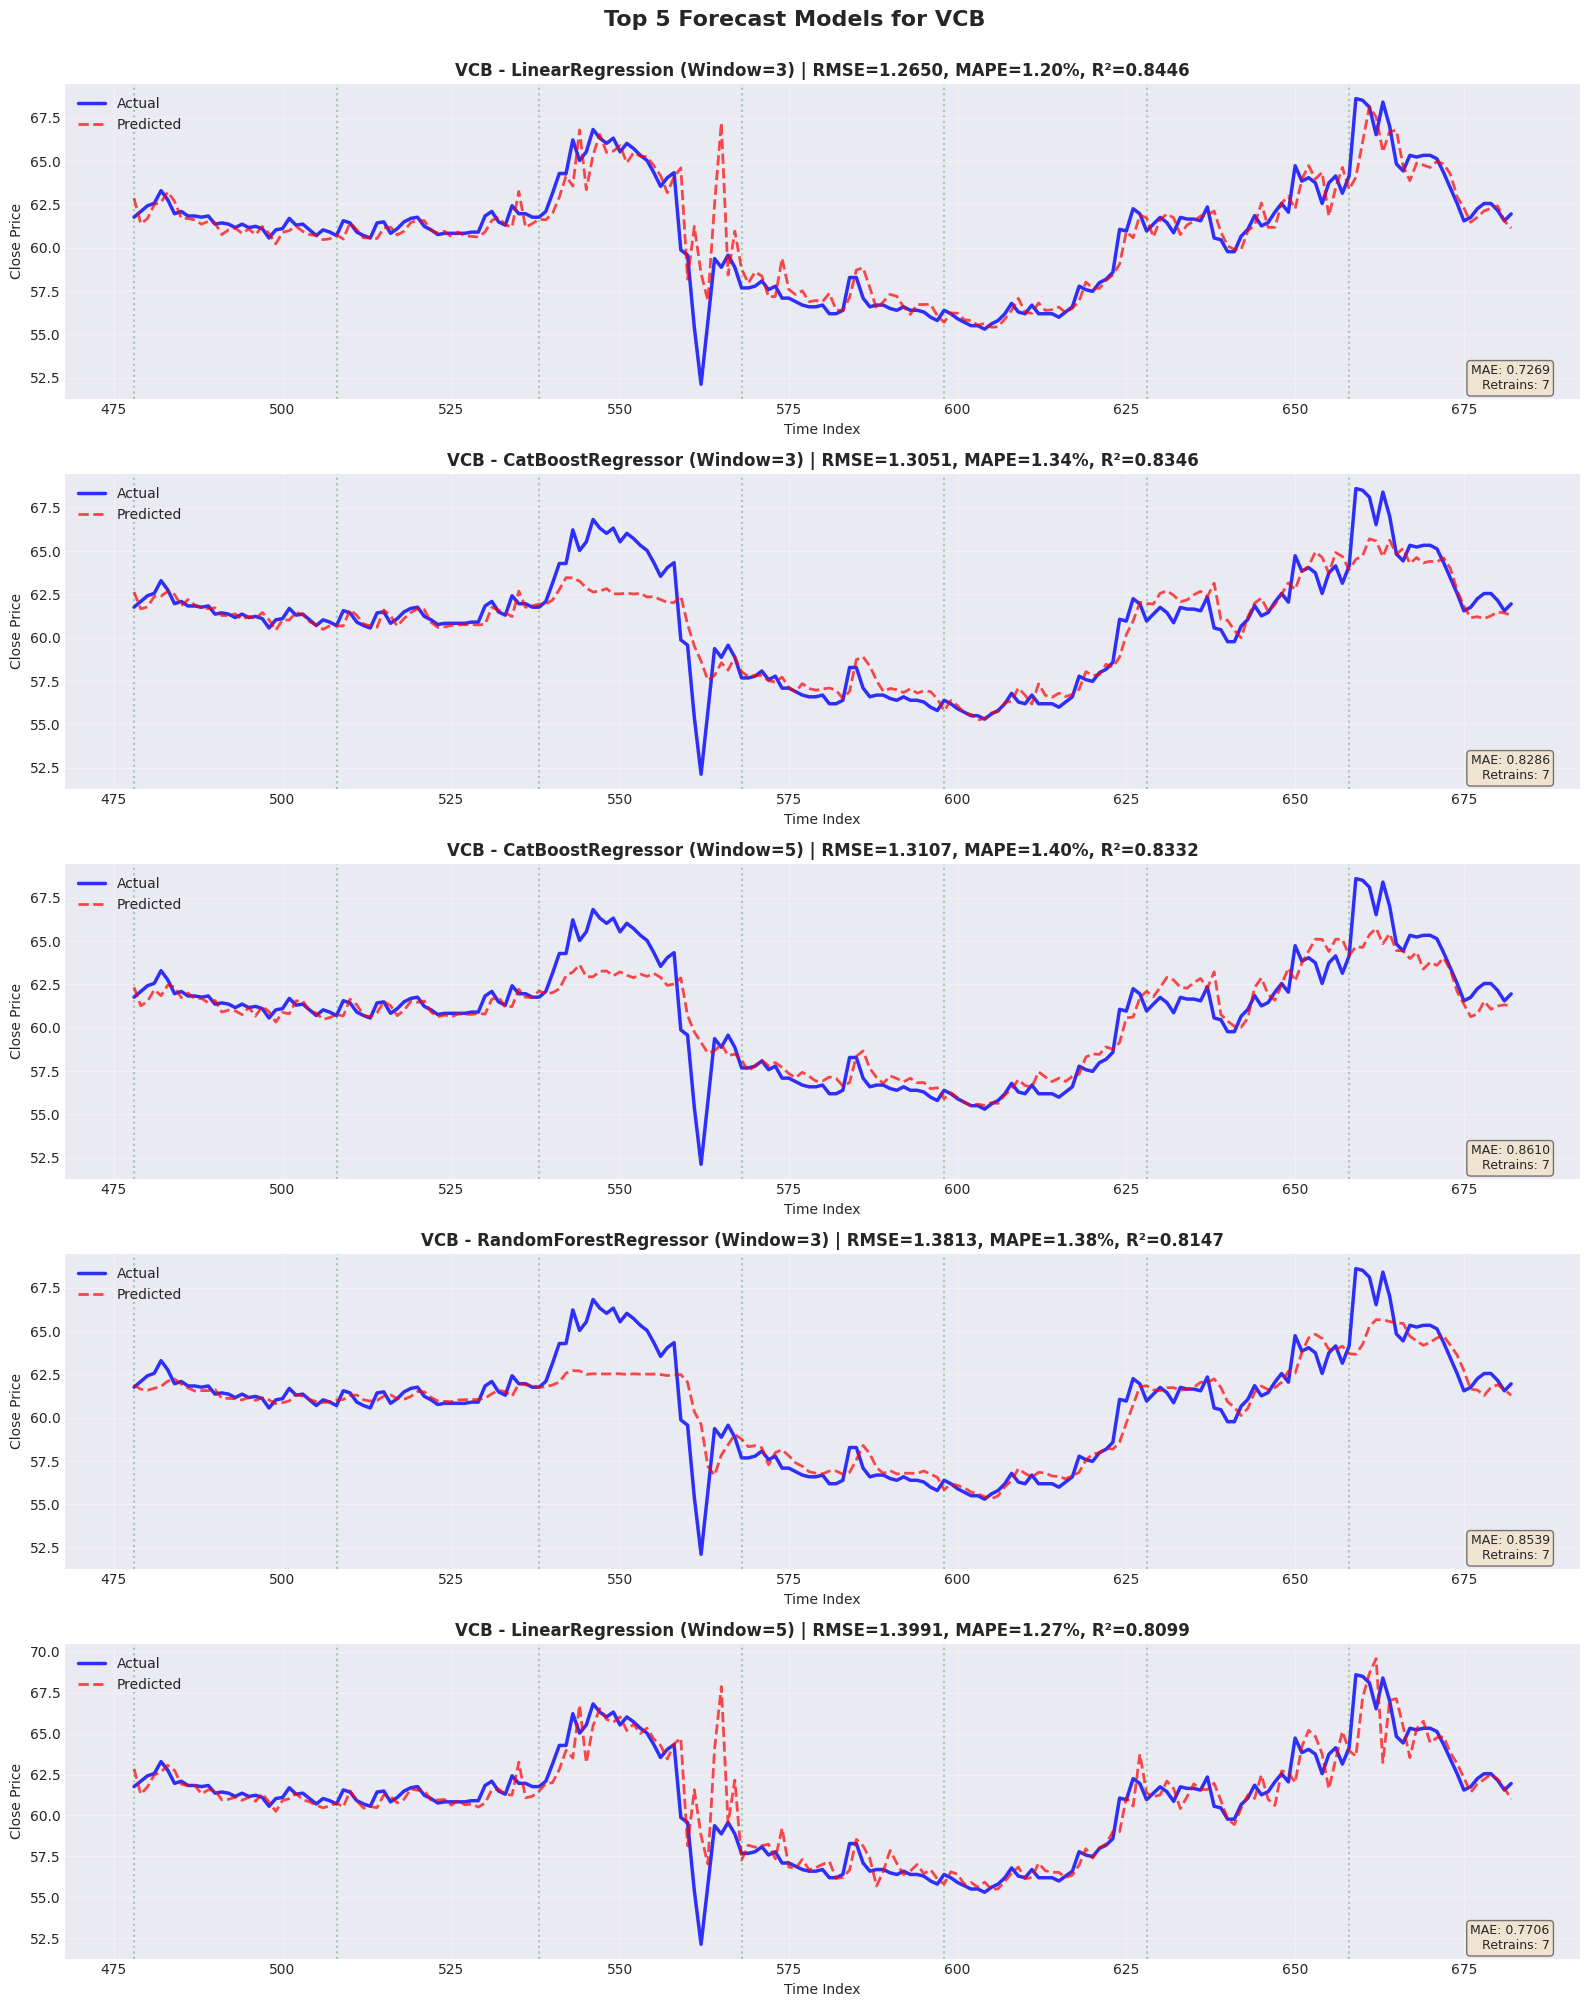


PLOTTING FORECASTS FOR ALL SYMBOLS
Symbols: ['ACB', 'BID', 'VCB', 'MBB', 'FPT']
Top 3 models per symbol


📊 Plotting ACB...


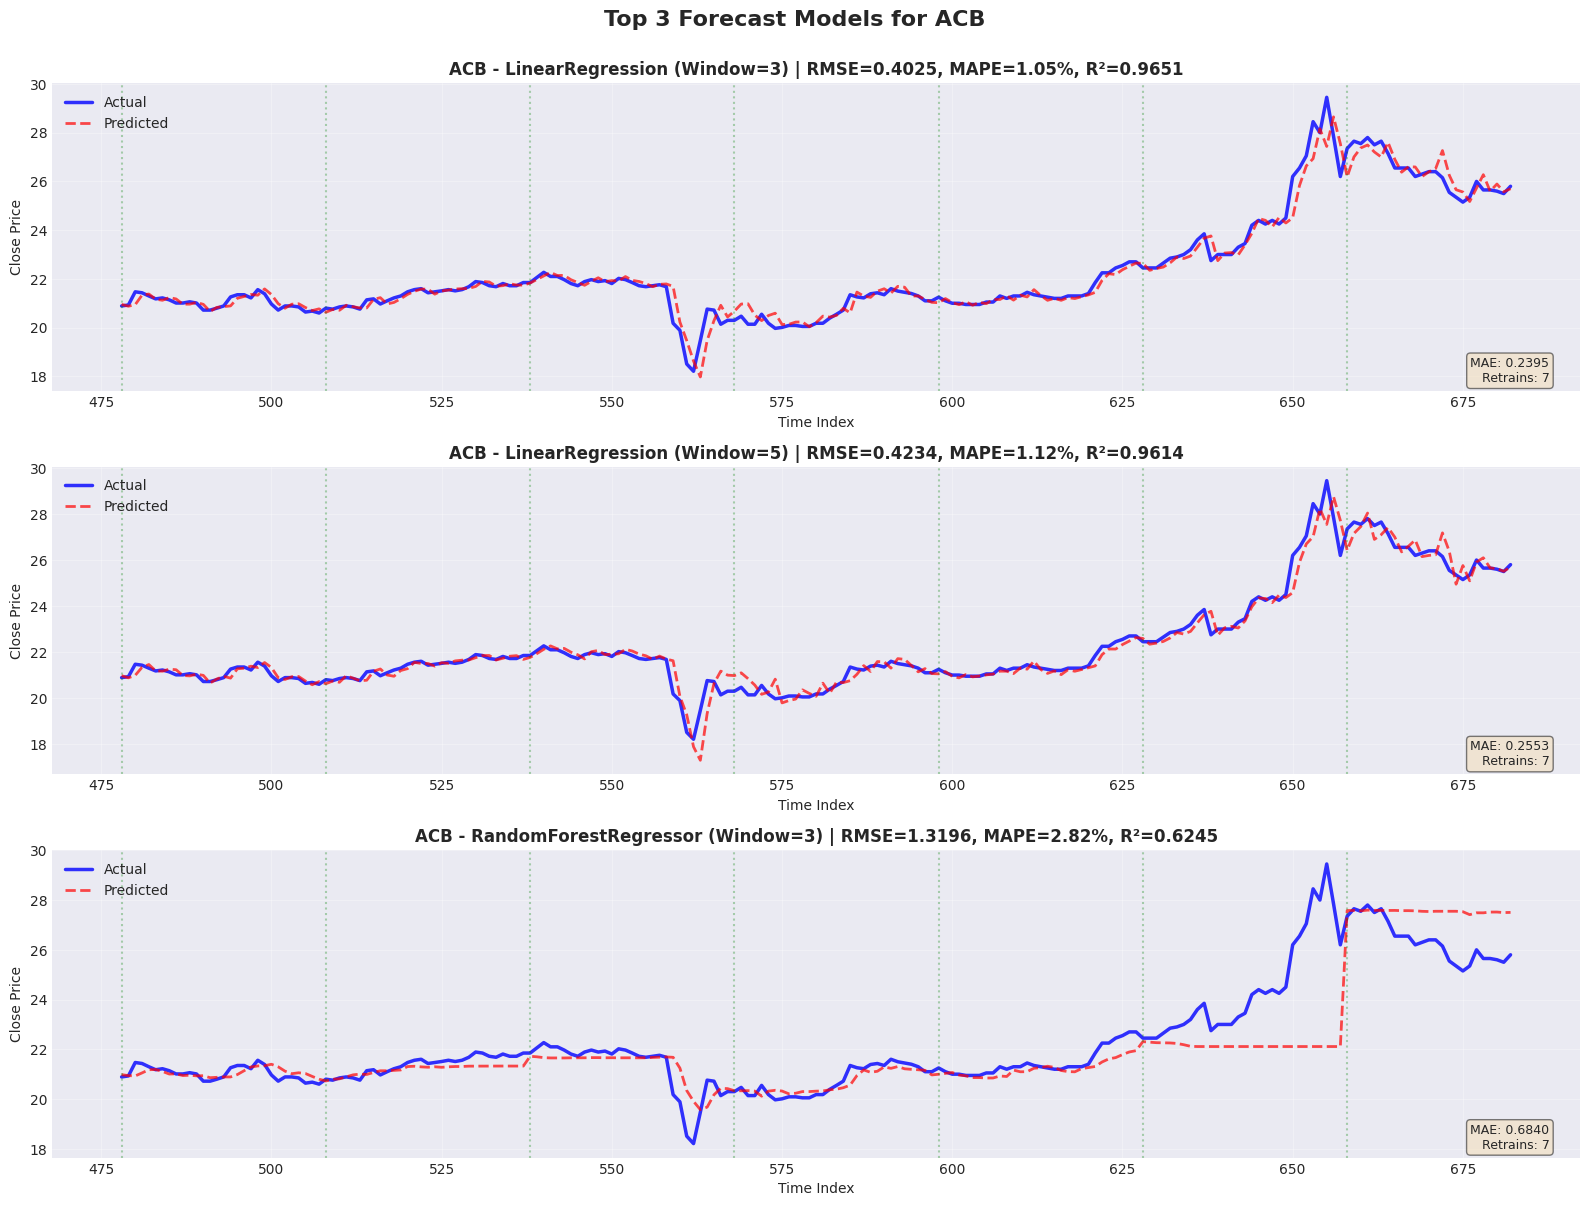


📊 Plotting BID...


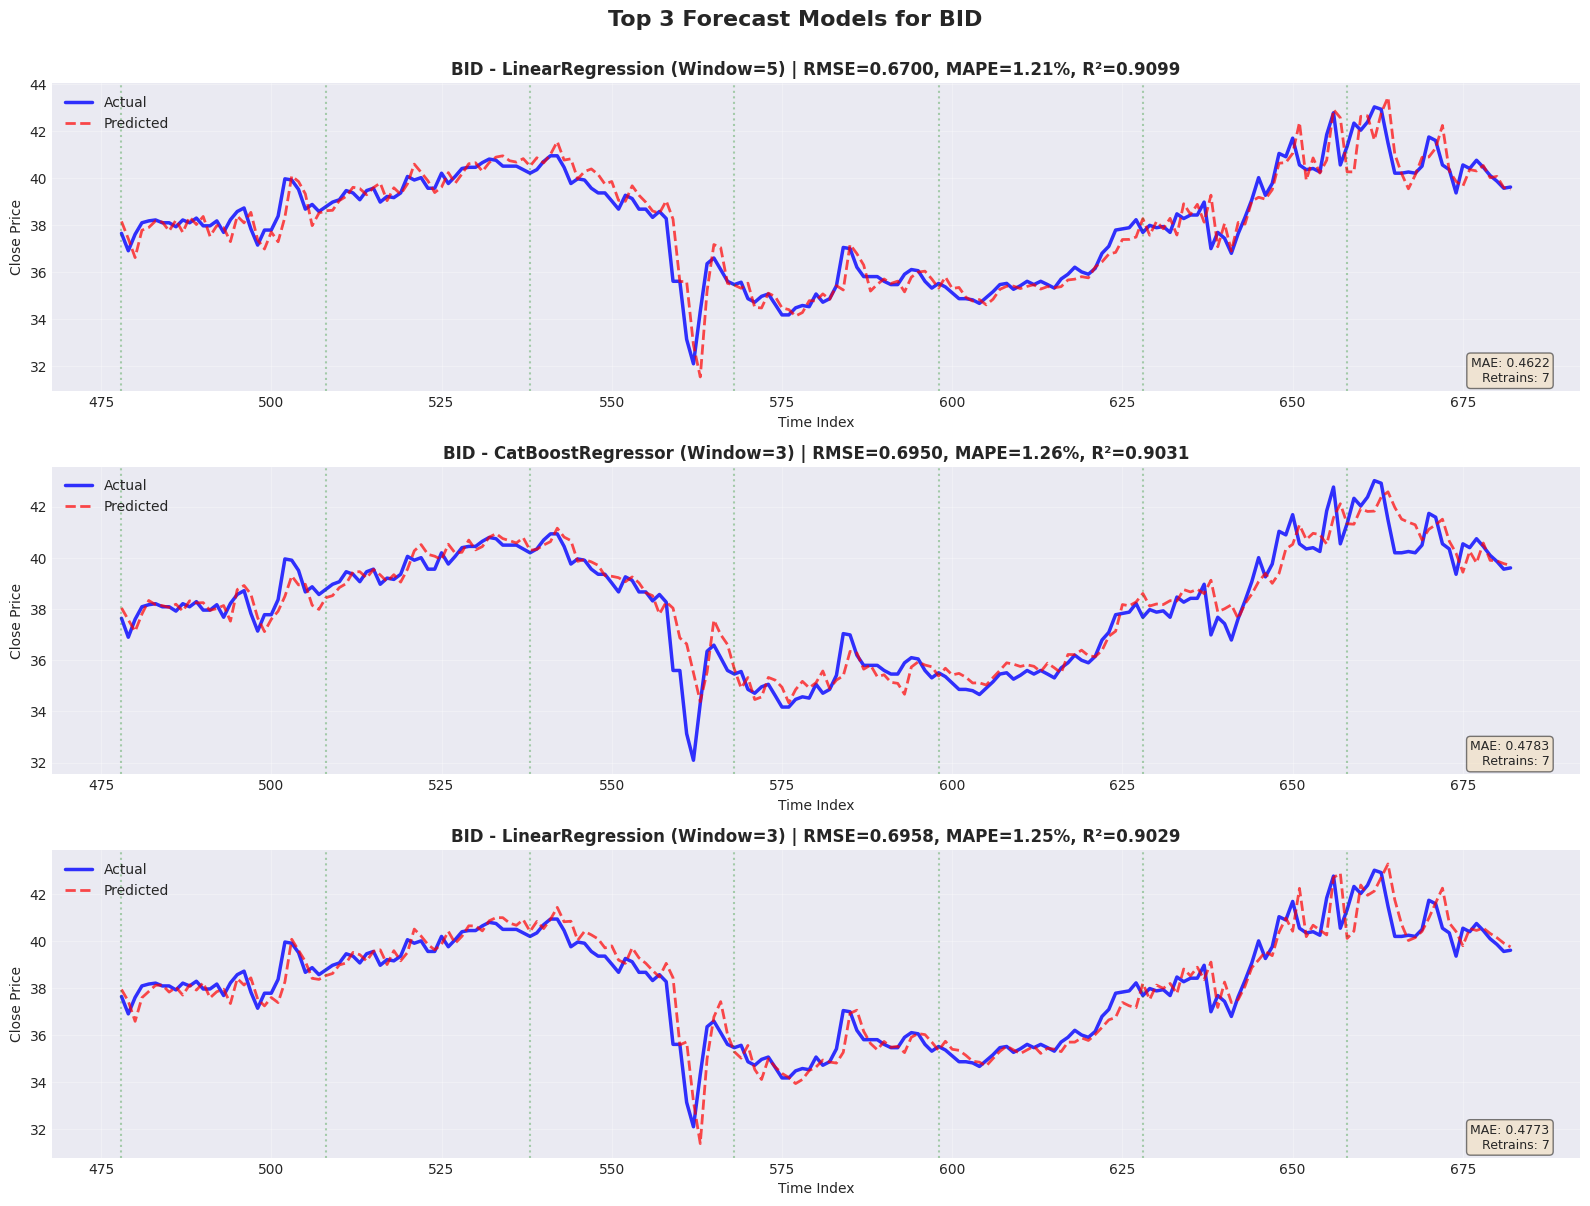


📊 Plotting VCB...


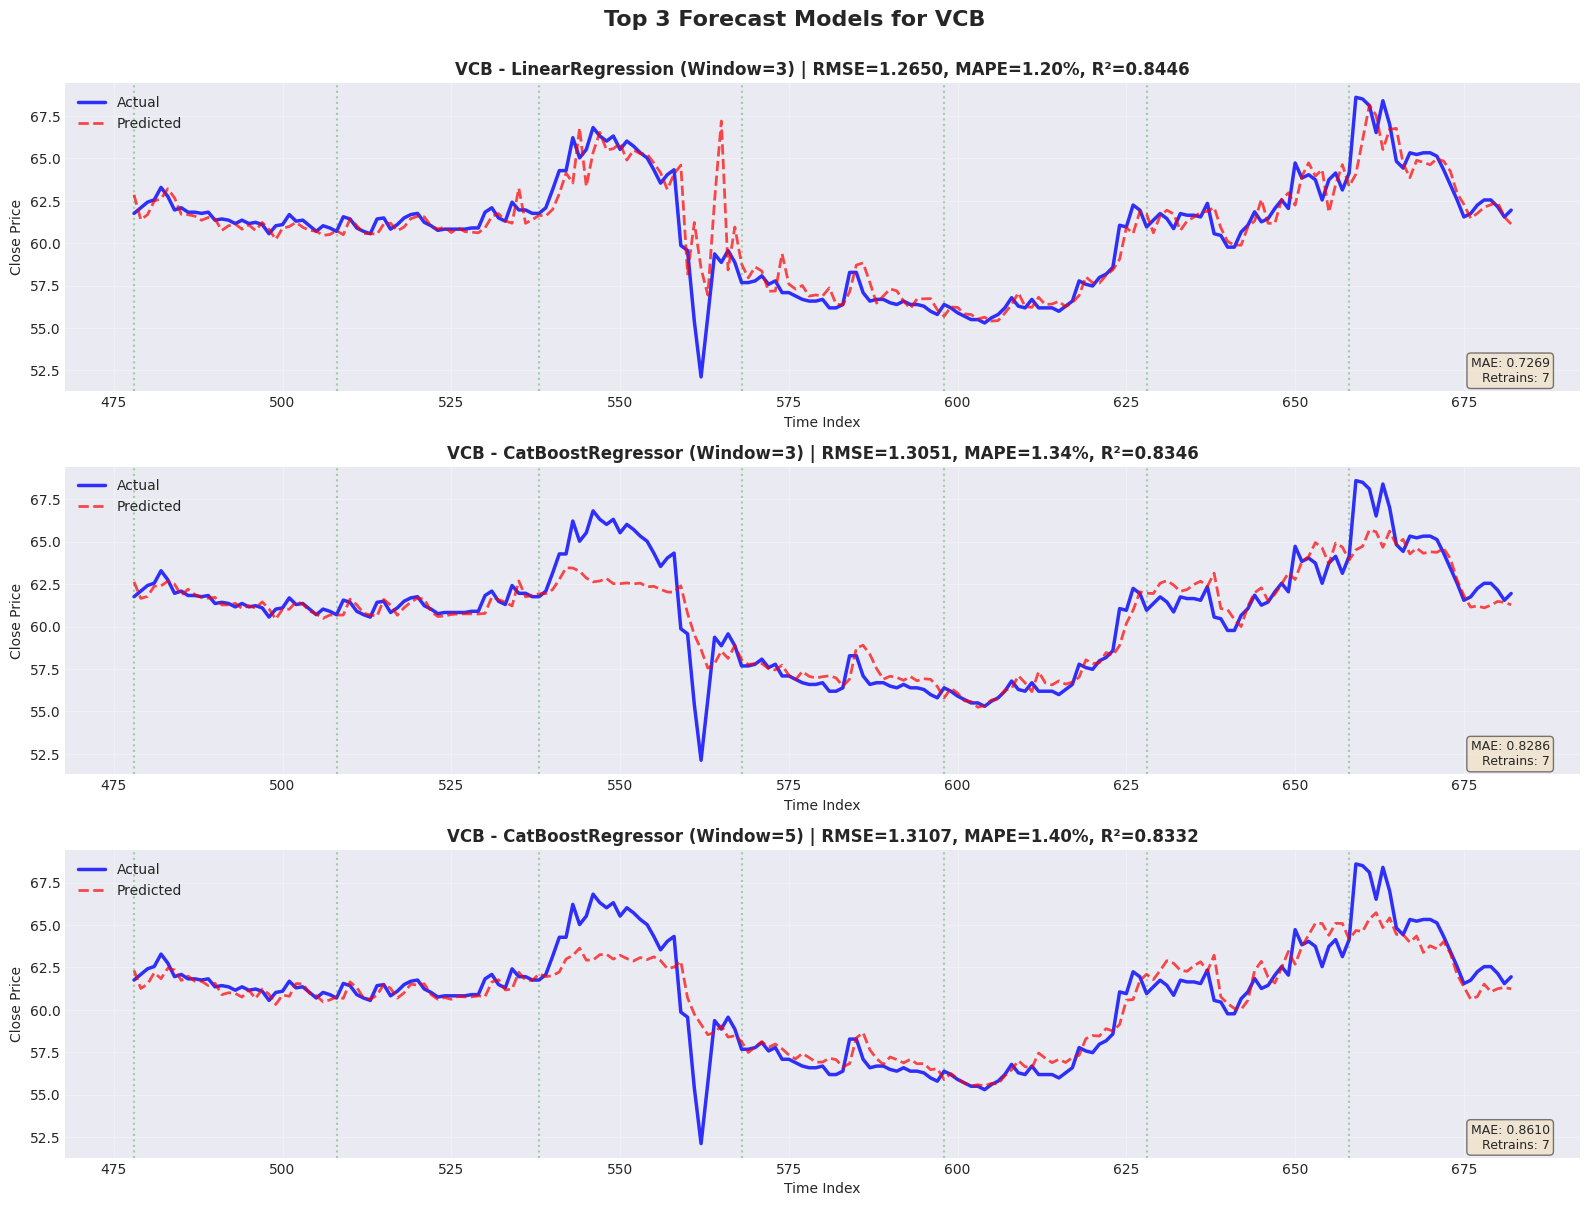


📊 Plotting MBB...


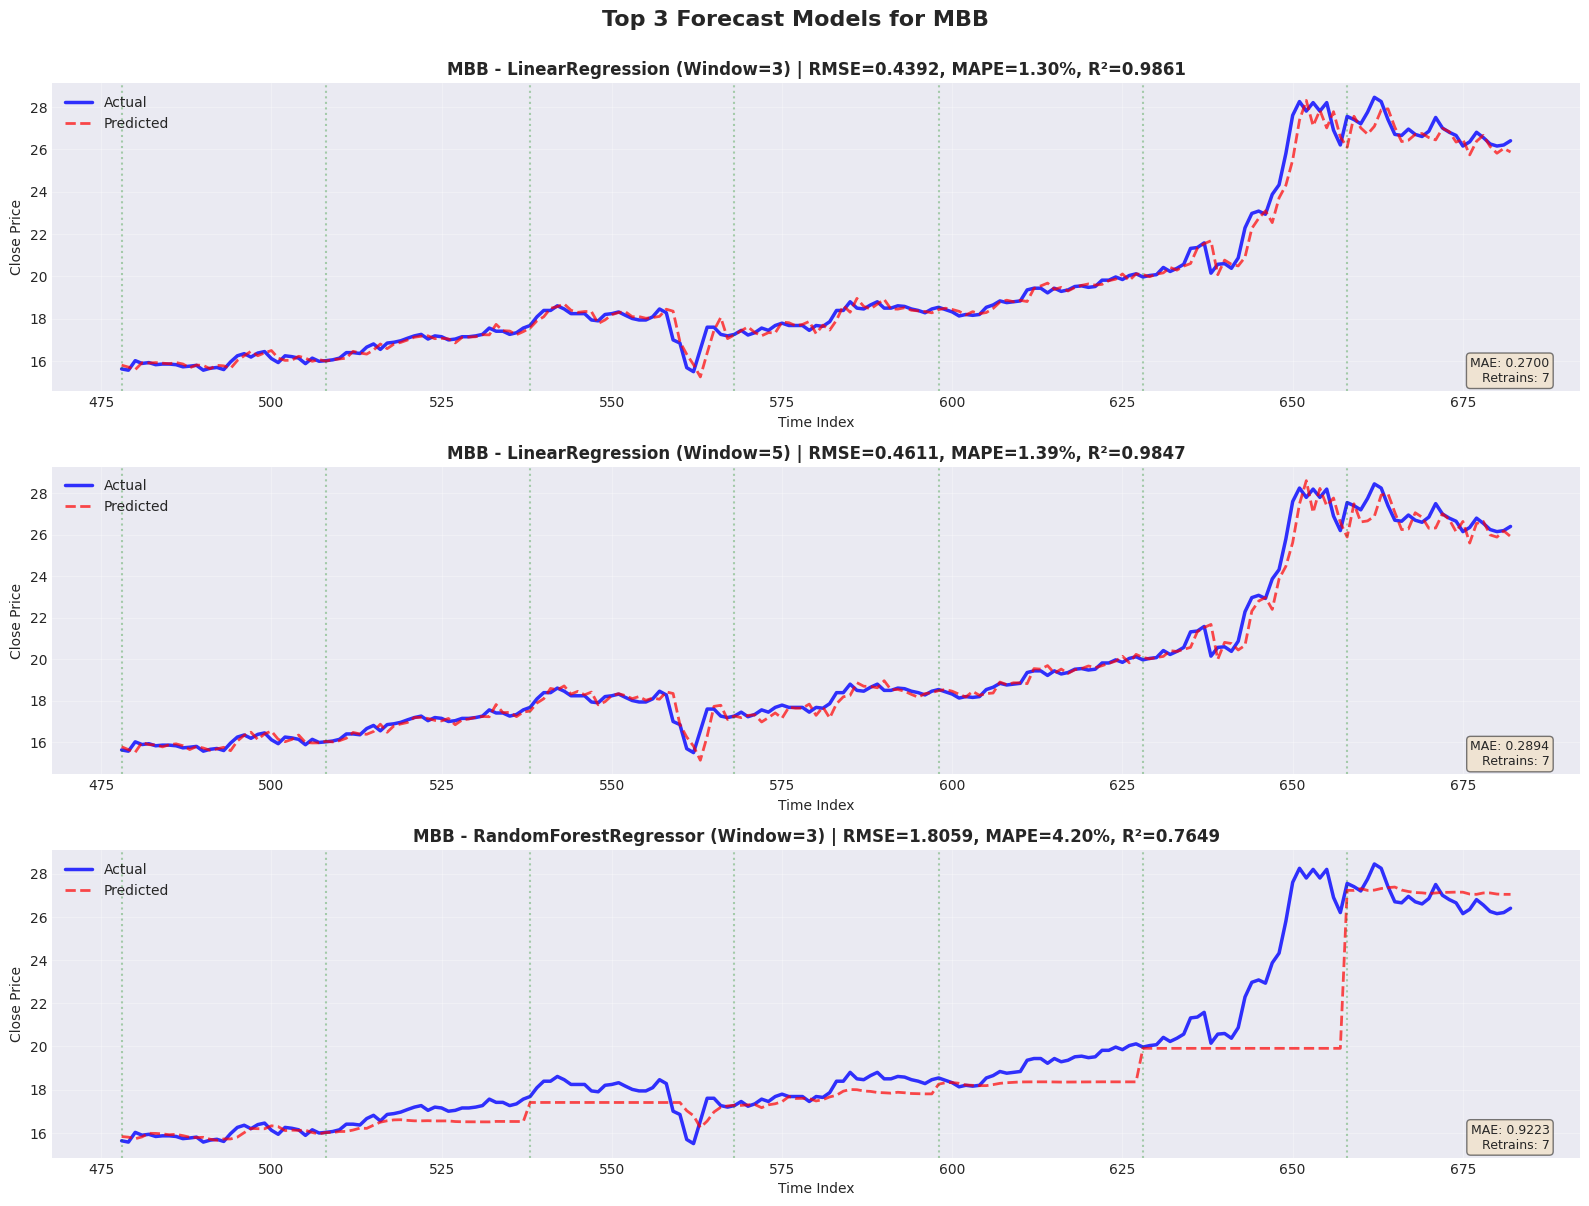


📊 Plotting FPT...


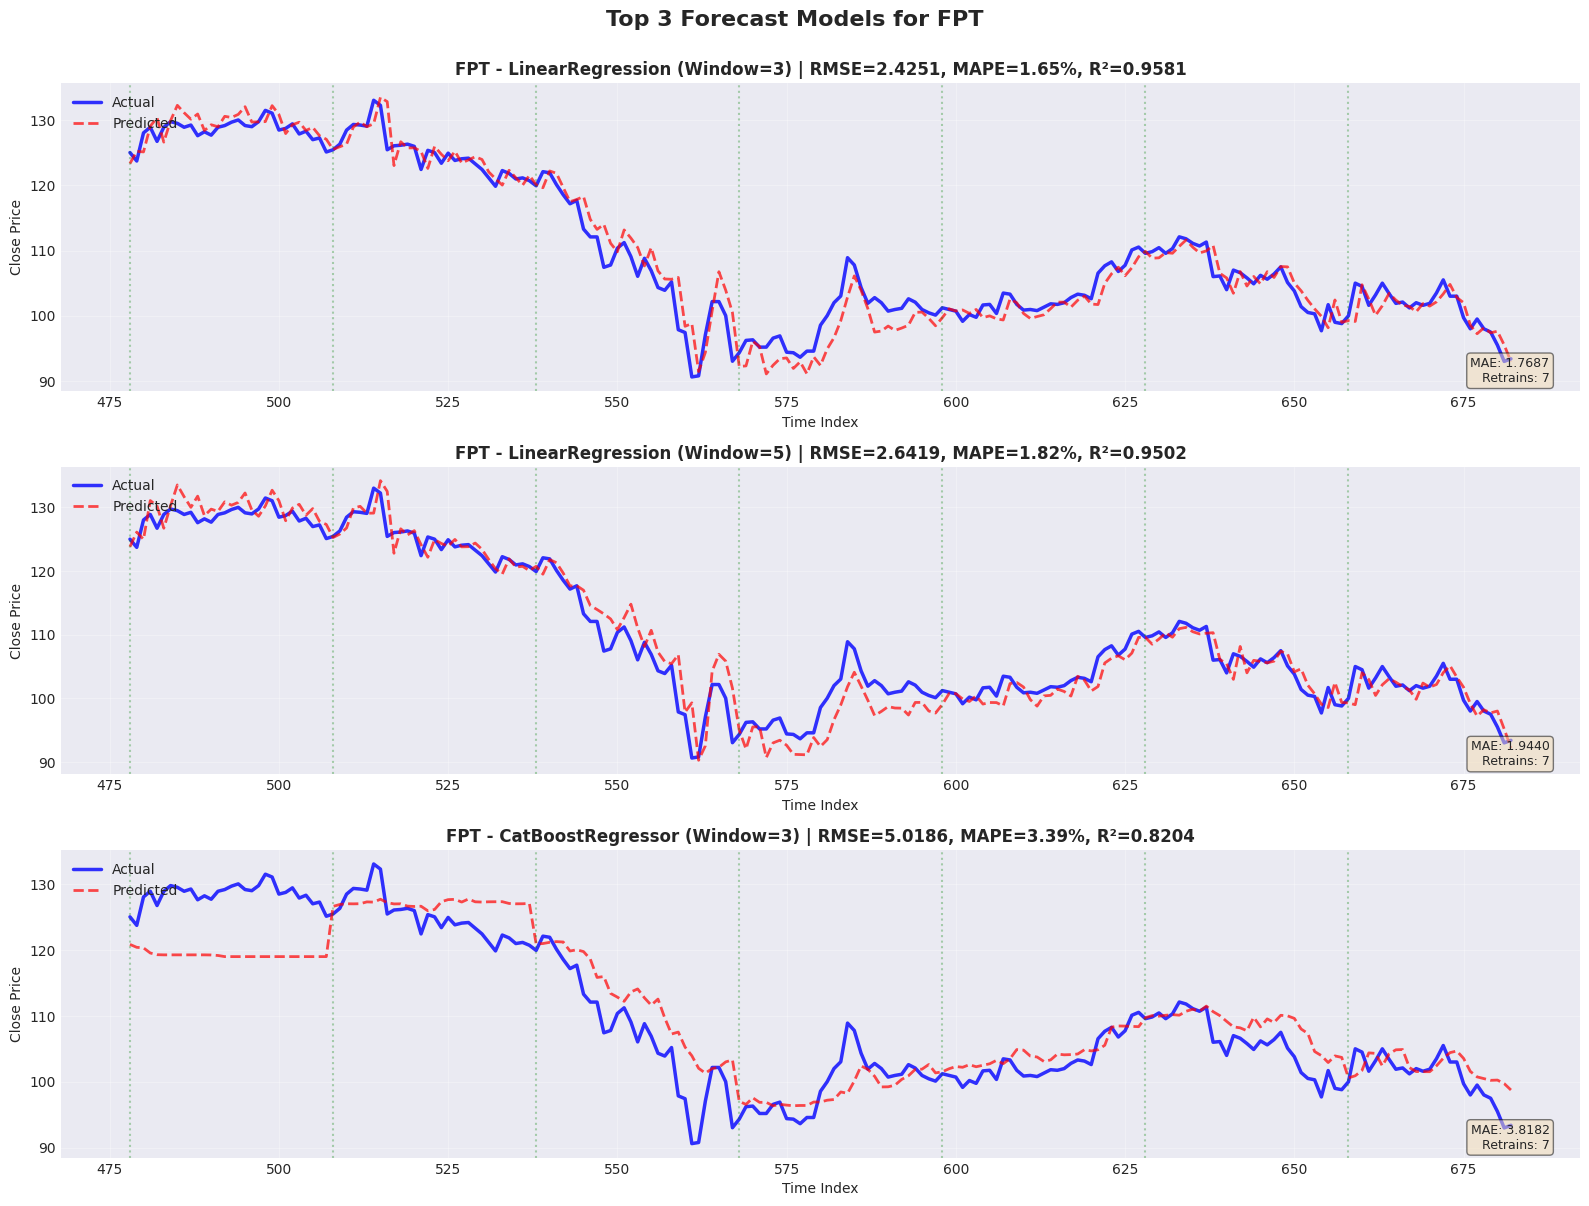

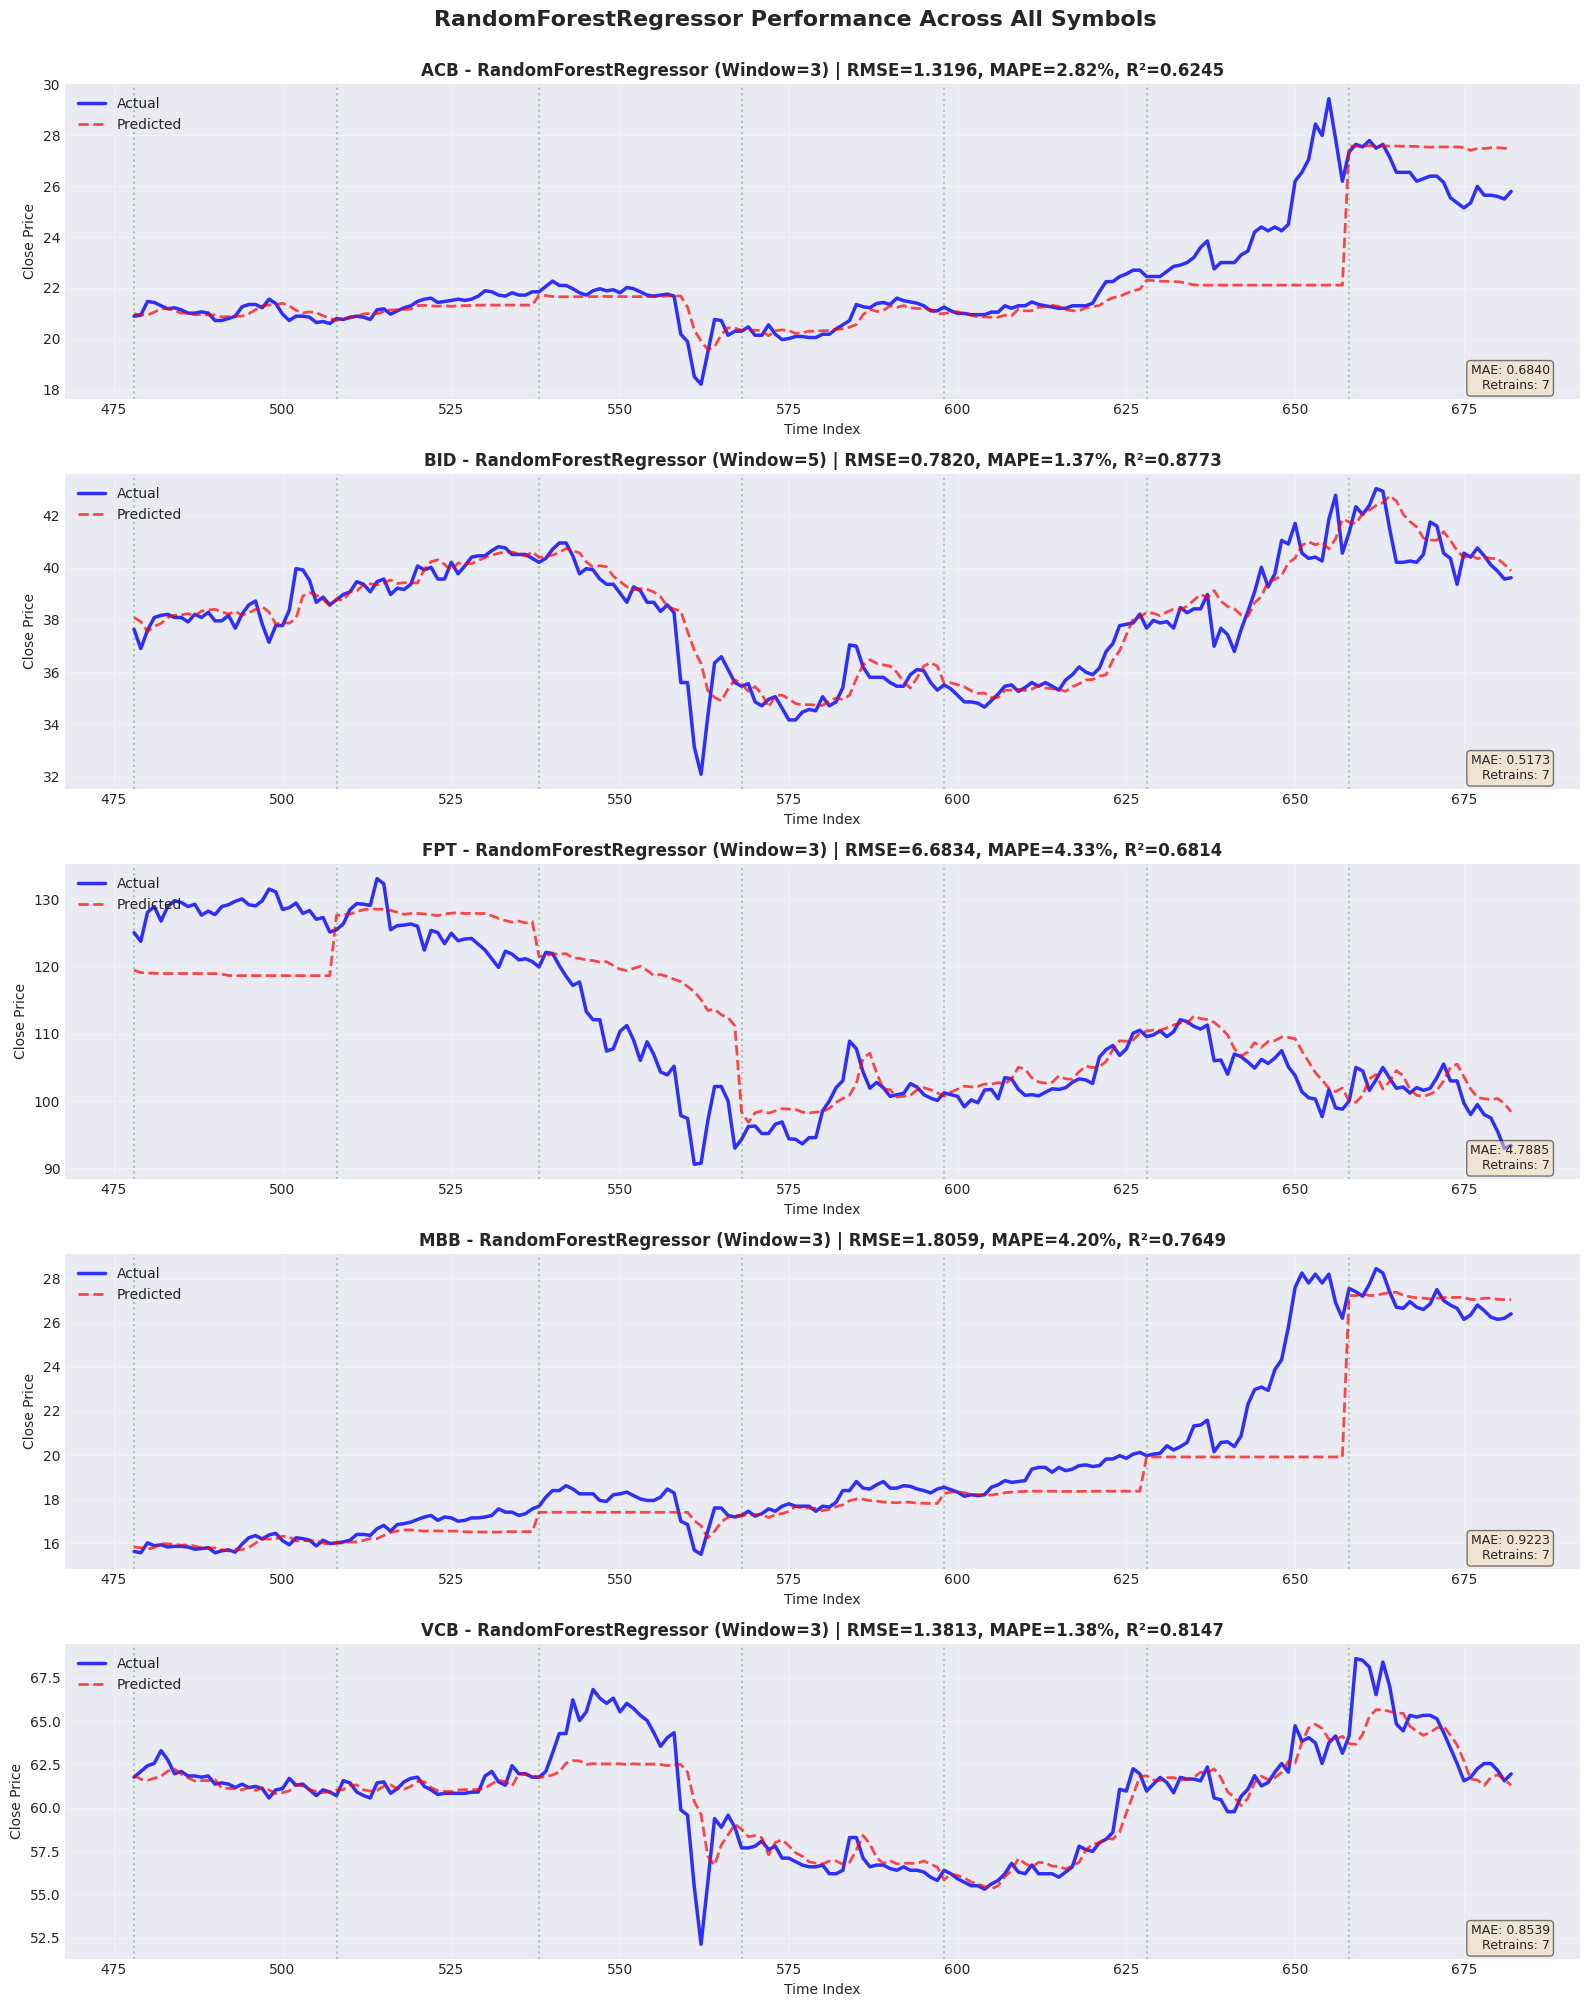

❌ No results found for model LGBMRegressor


In [29]:
# Example: Plot forecasts sau khi training
# CHỈ CHẠY SAU KHI ĐÃ TRAINING XONG!

# Kiểm tra xem đã có walkforward_df chưa
try:
    if 'walkforward_df' in locals() and len(walkforward_df) > 0:
        print("✅ walkforward_df đã tồn tại với {} results".format(len(walkforward_df)))
        print("\nBạn có thể uncomment các dòng dưới để visualize:\n")
        
        # Option 1: Plot top 5 models cho VCB
        plot_forecast_by_symbol(walkforward_df, 'VCB', df_ind_clean, top_n_models=5)
        
        # Option 2: Plot top 3 models cho TẤT CẢ symbols
        plot_all_symbols_forecast(walkforward_df, df_ind_clean, top_n_models=3)
        
        # Option 3: So sánh RandomForestRegressor trên tất cả symbols
        plot_model_comparison(walkforward_df, 'RandomForestRegressor', df_ind_clean)
        
        # Option 4: So sánh LightGBM trên tất cả symbols
        plot_model_comparison(walkforward_df, 'LGBMRegressor', df_ind_clean)
        
    else:
        print("⚠️  walkforward_df chưa có hoặc rỗng")
        print("\n📋 CÁC BƯỚC CẦN THỰC HIỆN:")
        print("="*60)
        print("1. Tìm cell 'Full Training với Walk-Forward Realistic' (cell 38)")
        print("2. Set: RUN_WALKFORWARD_TRAINING = True")
        print("3. Chọn config: 'MINIMAL' (nhanh ~5min) hoặc 'BALANCED' (~15min)")
        print("4. Chạy cell đó để train")
        print("5. Sau khi train xong, quay lại cell này và uncomment code")
        print("="*60)
        
except NameError:
    print("❌ walkforward_df chưa được tạo")
    print("\n📋 HƯỚNG DẪN:")
    print("="*60)
    print("Bạn cần TRAIN models trước khi visualize!")
    print("\nCÁCH 1: Walk-Forward Training (KHUYẾN NGHỊ)")
    print("  → Tìm cell 'Full Training với Walk-Forward Realistic'")
    print("  → Set RUN_WALKFORWARD_TRAINING = True")
    print("  → Chọn config phù hợp (MINIMAL/BALANCED/COMPREHENSIVE)")
    print("  → Chạy cell để train")
    print("\nCÁCH 2: Selected Features Training")
    print("  → Chạy Feature Importance Analysis trước (cell 32-33)")
    print("  → Sau đó train với selected features")
    print("="*60)